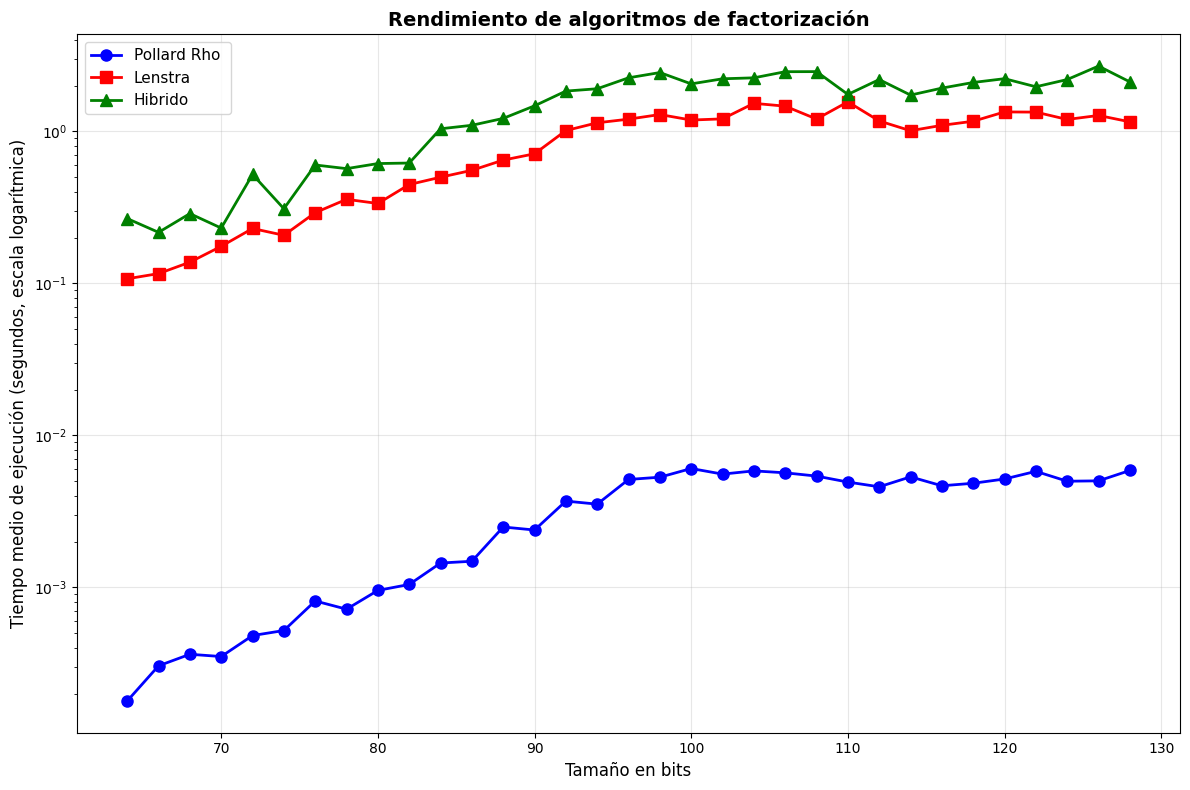

=== Data Summary ===
Total number of records: 3300
Bit sizes analyzed: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]
Numbers per bit size:
bit_size
64     100
66     100
68     100
70     100
72     100
74     100
76     100
78     100
80     100
82     100
84     100
86     100
88     100
90     100
92     100
94     100
96     100
98     100
100    100
102    100
104    100
106    100
108    100
110    100
112    100
114    100
116    100
118    100
120    100
122    100
124    100
126    100
128    100
Name: count, dtype: int64

=== Method Success Rates ===
Pollard Rho: 100.0%
Lenstra ECM: 100.0%

=== Mean Execution Times by Bit Size ===
          pollard_time  lenstra_time  hibrido_time
bit_size                                          
64            0.000179      0.107146      0.266716
66            0.000305      0.115901      0.216426
68            0.000364      0.137759      0.2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from collections import defaultdict

def analyze_factorization_times(filename, methods=None, custom_labels=None):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if line: 
                try:
                    record = ast.literal_eval(line)
                    data.append(record)
                except (ValueError, SyntaxError) as e:
                    print(f"Warning: Could not parse line: {line}")
                    continue
    
    if not data:
        raise ValueError("No valid data found in the file")
    
    df = pd.DataFrame(data)
    
    if methods is None:
        timing_columns = [col for col in df.columns if col.endswith('_time')]
        if not timing_columns:
            raise ValueError("No timing columns found. Expected columns ending with '_time'")
    else:
        timing_columns = methods
        missing_cols = [col for col in timing_columns if col not in df.columns]
        if missing_cols:
            print(f"Warning: The following specified methods were not found in data: {missing_cols}")
            timing_columns = [col for col in timing_columns if col in df.columns]
    
    aggregated_data = defaultdict(dict)
    
    for bit_size in df['bit_size'].unique():
        bit_data = df[df['bit_size'] == bit_size]
        
        for col in timing_columns:
            if col in bit_data.columns:
                mean_time = bit_data[col].mean()
                aggregated_data[bit_size][col] = mean_time
    
    agg_df = pd.DataFrame.from_dict(aggregated_data, orient='index')
    agg_df.index.name = 'bit_size'
    agg_df = agg_df.sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', '>', '<']
    
    method_info = {}
    for i, method in enumerate(timing_columns):
        label = method.replace('_time', '').replace('_', ' ').title()
        method_info[method] = {
            'color': colors[i % len(colors)],
            'label': label,
            'marker': markers[i % len(markers)]
        }
        
        if custom_labels and method in custom_labels:
            method_info[method]['label'] = custom_labels[method]
    
    for method in timing_columns:
        if method in agg_df.columns and method in method_info:
            mask = (agg_df[method].notna())
            if mask.any():
                info = method_info[method]
                ax.plot(agg_df.index[mask], agg_df[method][mask], 
                       color=info['color'], label=info['label'], 
                       marker=info['marker'], markersize=8, linewidth=2)
    
    ax.set_xlabel('Tamaño en bits', fontsize=12)
    ax.set_ylabel('Tiempo medio de ejecución (segundos)', fontsize=12)
    ax.set_title('Rendimiento de algoritmos de factorización', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    if agg_df[timing_columns].max().max() / agg_df[timing_columns][agg_df[timing_columns] > 0].min().min() > 100:
        ax.set_yscale('log')
        ax.set_ylabel('Tiempo medio de ejecución (segundos, escala logarítmica)', fontsize=12)
    
    plt.tight_layout()
    
    return agg_df, fig

def display_summary_statistics(df, agg_df):
    print("=== Data Summary ===")
    print(f"Total number of records: {len(df)}")
    print(f"Bit sizes analyzed: {sorted(df['bit_size'].unique())}")
    print(f"Numbers per bit size:")
    print(df['bit_size'].value_counts().sort_index())
    
    print("\n=== Method Success Rates ===")
    success_rates = {}
    
    if 'pollardP-1_factor' in df.columns:
        success_rates['Pollard P-1'] = (df['pollardP_1_factor'].notna()).ean()* 100
    
    if 'pollard_factor' in df.columns:
        success_rates['Pollard Rho'] = (df['pollard_factor'].notna()).mean() * 100
    
    if 'lenstra_factor' in df.columns:
        success_rates['Lenstra ECM'] = (df['lenstra_factor'].notna()).mean() * 100
    
    for method, rate in success_rates.items():
        print(f"{method}: {rate:.1f}%")
    
    print("\n=== Mean Execution Times by Bit Size ===")
    print(agg_df.round(6))

if __name__ == "__main__":
    filename = 'resultados_debiles.txt'
    
    # Example 1: Auto-detect all timing methods
    # agg_df, fig = analyze_factorization_times(filename)
    
    # Example 2: Specify only certain methods
    # methods_to_analyze = ['pollard_time', 'lenstra_time']
    # agg_df, fig = analyze_factorization_times(filename, methods=methods_to_analyze)
    
    # Example 3: Use custom labels for methods
    custom_labels = {'2_time': 'Híbrido', 'pollard_time': 'Pollard Rho ','Lenstra_time':'Lenstra ECM'}
    # agg_df, fig = analyze_factorization_times(filename, custom_labels=custom_labels)
    
    try:
        agg_df, fig = analyze_factorization_times(filename, custom_labels=custom_labels)
        
        plt.show()
        
        data = []
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    try:
                        record = ast.literal_eval(line)
                        data.append(record)
                    except:
                        continue
        
        df = pd.DataFrame(data)
        display_summary_statistics(df, agg_df)
        
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        print("Please make sure your data file exists and update the filename variable.")
    except Exception as e:
        print(f"Error processing data: {e}")

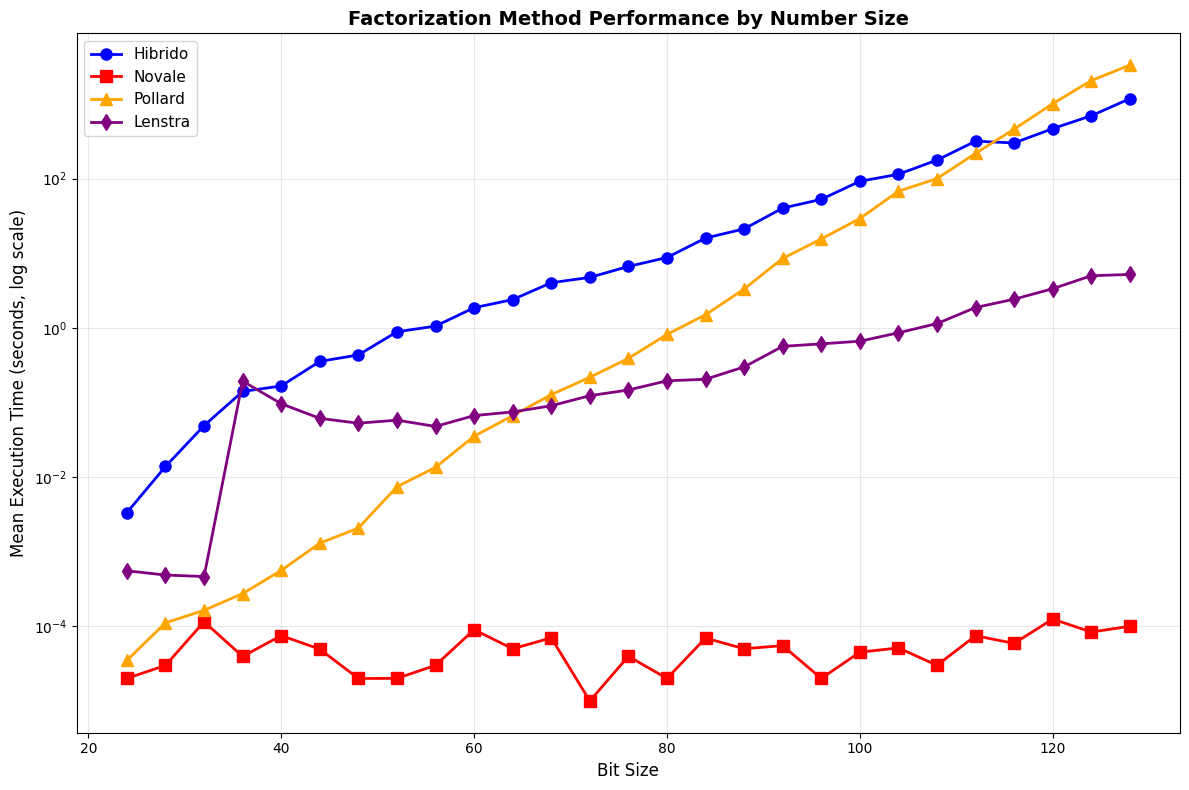

Analysis complete!
=== Data Summary ===
Total number of records: 5291
Bit sizes analyzed: [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128]
Numbers per bit size:
bit_size
24     200
28     200
32     200
36     200
40     200
44     200
48     200
52     200
56     200
60     200
64     200
68     200
72     200
76     200
80     200
84     200
88     200
92     200
96     200
100    200
104    200
108    200
112    200
116    200
120    200
124    171
128    120
Name: count, dtype: int64

=== Method Success Rates ===
Pollard Rho: 49.0%
Lenstra ECM: 49.0%

=== Mean Execution Times by Bit Size ===
          hibrido_time  novale_time  pollard_time  lenstra_time
bit_size                                                       
24            0.003340     0.000020      0.000035      0.000555
28            0.013861     0.000030      0.000111      0.000487
32            0.048935     0.000115      0.000164      0.000465
36       

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from collections import defaultdict

def analyze_factorization_times(filenames, custom_labels=None):
    if isinstance(filenames, str):
        filenames = [filenames]
    
    all_data = []
    
    for filename in filenames:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    try:
                        record = ast.literal_eval(line)
                        all_data.append(record)
                    except (ValueError, SyntaxError):
                        continue
    
    if not all_data:
        raise ValueError("No valid data found in files")
    
    df = pd.DataFrame(all_data)
    
    timing_columns = [col for col in df.columns if col.endswith('_time') or col.isdigit()]
    
    aggregated_data = defaultdict(dict)
    
    for bit_size in df['bit_size'].unique():
        bit_data = df[df['bit_size'] == bit_size]
        for col in timing_columns:
            if col in bit_data.columns:
                aggregated_data[bit_size][col] = bit_data[col].mean()
    
    agg_df = pd.DataFrame.from_dict(aggregated_data, orient='index')
    agg_df.index.name = 'bit_size'
    agg_df = agg_df.sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = ['blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', '>', '<']
    
    for i, method in enumerate(timing_columns):
        if method in agg_df.columns:
            mask = (agg_df[method] > 0) & (agg_df[method].notna())
            if mask.any():
                if custom_labels and method in custom_labels:
                    label = custom_labels[method]
                else:
                    label = method.replace('_time', '').replace('_', ' ').title()
                
                ax.plot(agg_df.index[mask], agg_df[method][mask], 
                       color=colors[i % len(colors)], label=label, 
                       marker=markers[i % len(markers)], markersize=8, linewidth=2)
    
    ax.set_xlabel('Bit Size', fontsize=12)
    ax.set_ylabel('Mean Execution Time (seconds)', fontsize=12)
    ax.set_title('Factorization Method Performance by Number Size', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    if timing_columns and not agg_df[timing_columns].empty:
        max_val = agg_df[timing_columns].max().max()
        min_val = agg_df[timing_columns][agg_df[timing_columns] > 0].min().min()
        if pd.notna(max_val) and pd.notna(min_val) and min_val > 0 and max_val / min_val > 100:
            ax.set_yscale('log')
            ax.set_ylabel('Mean Execution Time (seconds, log scale)', fontsize=12)
    
    plt.tight_layout()
    
    return df, agg_df, fig

if __name__ == "__main__":
    files = ['resultados_3_aprox128.txt', 'resultados_sympy.txt']
    
    try:
        df, agg_df, fig = analyze_factorization_times(files, custom_labels={'2_time': 'hibrido'})
        plt.show()
        print("Analysis complete!")
        display_summary_statistics(df, agg_df)
    except FileNotFoundError as e:
        print(f"Error: Could not find file. {e}")
    except Exception as e:
        print(f"Error during analysis: {e}")

Error during analysis: "['novale_time', 'IMP_lenstra_time', 'IMP_pollard_rho_time'] not in index"


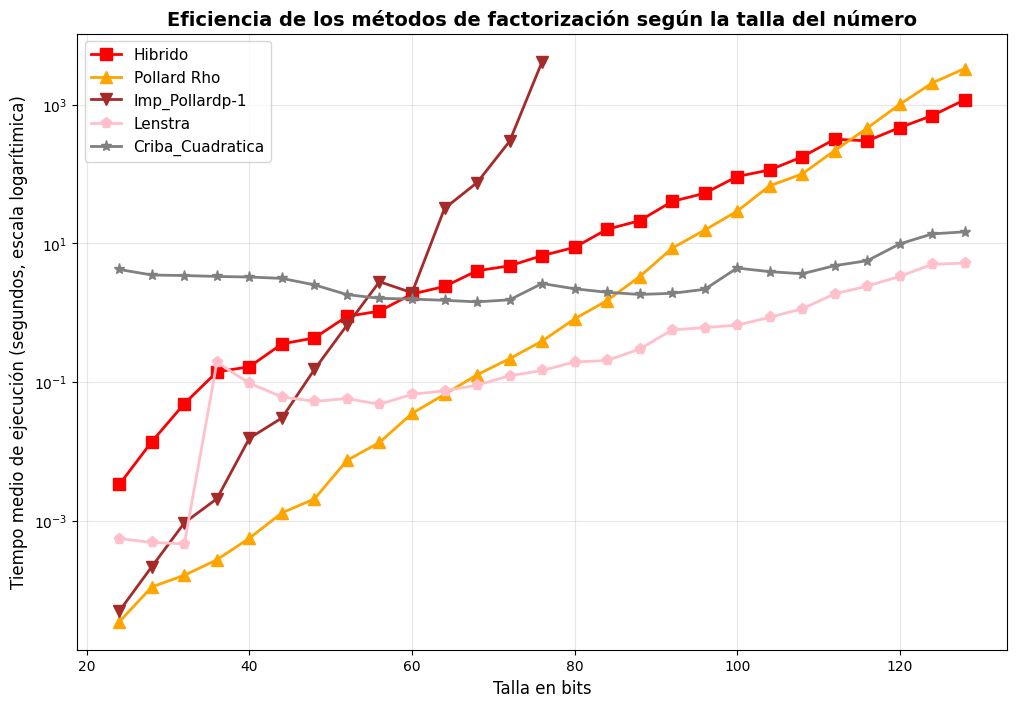

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from collections import defaultdict

def analyze_factorization_times(filenames, custom_labels=None, exclude_methods=[]):
    if isinstance(filenames, str):
        filenames = [filenames]
    
    all_data = []
    
    for filename in filenames:
        with open(filename, 'r') as file:
            for line in file:
                line = line.strip()
                if line:
                    try:
                        record = ast.literal_eval(line)
                        all_data.append(record)
                    except (ValueError, SyntaxError):
                        continue
    
    if not all_data:
        raise ValueError("No valid data found in files")
    
    df = pd.DataFrame(all_data)
    
    timing_columns = [col for col in df.columns if col.endswith('_time') or col in ['2']]
    
    if custom_labels:
        timing_columns.extend([col for col in custom_labels.keys() if col in df.columns])
    
    timing_columns = list(set(timing_columns))
    
    aggregated_data = defaultdict(dict)
    
    for bit_size in df['bit_size'].unique():
        bit_data = df[df['bit_size'] == bit_size]
        for col in timing_columns:
            if col in bit_data.columns and col not in exclude_methods:
                aggregated_data[bit_size][col] = bit_data[col].mean()
    
    agg_df = pd.DataFrame.from_dict(aggregated_data, orient='index')
    agg_df.index.name = 'bit_size'
    agg_df = agg_df.sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = ['blue', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', '>', '<']
    
    for i, method in enumerate(timing_columns):
        if method in agg_df.columns:
            mask = (agg_df[method] > 0) & (agg_df[method].notna())
            if mask.any():
                if custom_labels and method in custom_labels:
                    label = custom_labels[method]
                elif method == '2':
                    label = 'Hibrido'
                else:
                    label = method.replace('_time', '').title()
                
                ax.plot(agg_df.index[mask], agg_df[method][mask], 
                       color=colors[i % len(colors)], label=label, 
                       marker=markers[i % len(markers)], markersize=8, linewidth=2)
    
    ax.set_xlabel('Talla en bits', fontsize=12)
    ax.set_yscale('log')
    ax.set_ylabel('Tiempo medio de ejecución (segundos, escala logarítimica)', fontsize=12)
    ax.set_title('Eficiencia de los métodos de factorización según la talla del número', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    if timing_columns and not agg_df[timing_columns].empty:
        max_val = agg_df[timing_columns].max().max()
        min_val = agg_df[timing_columns][agg_df[timing_columns] > 0].min().min()
            
    

    plt.tight_layout()
    
    return df, agg_df, fig

if __name__ == "__main__":
    files = ['resultados_3_aprox128.txt', 'resultados_sinhibrido.txt','resultados_sympy.txt','resultados_criba_cuadrática.txt']
    
    try:
        df, agg_df, fig = analyze_factorization_times(files, custom_labels={'2_time': 'Híbrido','pollard_time':'Pollard Rho'},exclude_methods=['novale_time','IMP_lenstra_time', 'IMP_pollard_rho_time'])
        plt.show()
        print("Analysis complete!")
        display_summary_statistics(df, agg_df)
    except FileNotFoundError as e:
        print(f"Error: Could not find file. {e}")
    except Exception as e:
        print(f"Error during analysis: {e}")

Error during analysis: "['novale_time', 'IMP_lenstra_time', 'IMP_pollard_rho_time'] not in index"


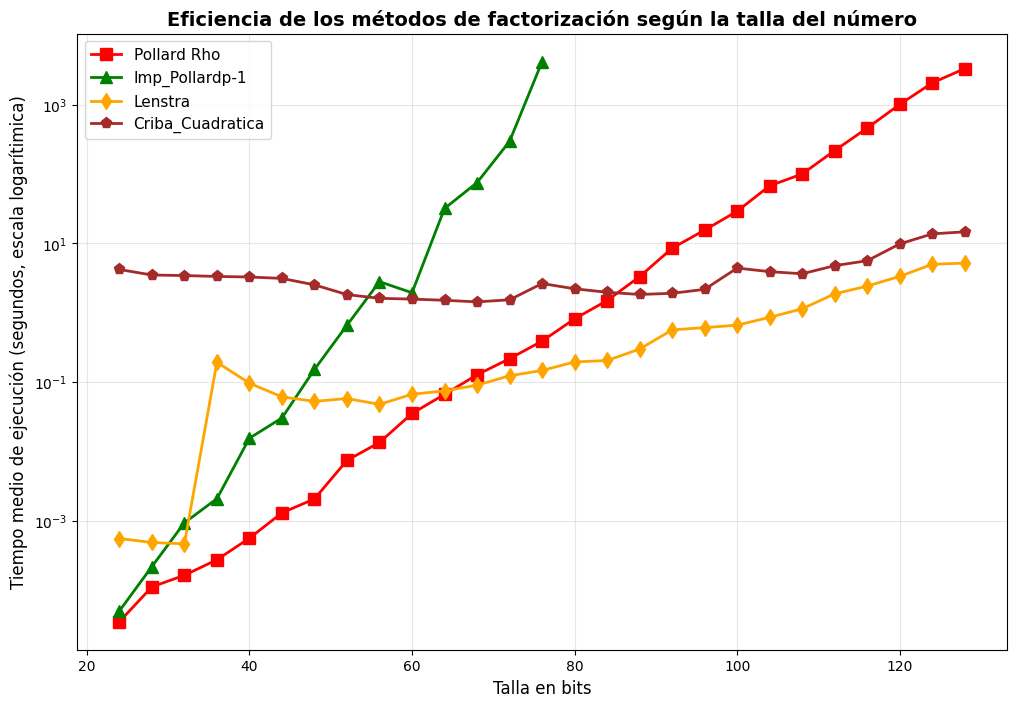

In [5]:
if __name__ == "__main__":
    files = ['resultados_sympy.txt', 'resultados_sinhibrido.txt', 'resultados_criba_cuadrática.txt']
    
    try:
        df, agg_df, fig = analyze_factorization_times(files, custom_labels={'pollard_time': 'Pollard Rho'}, exclude_methods=['novale_time','IMP_lenstra_time', 'IMP_pollard_rho_time'])
        plt.show()
        print("Analysis complete!")
        display_summary_statistics(df, agg_df)
    except FileNotFoundError as e:
        print(f"Error: Could not find file. {e}")
    except Exception as e:
        print(f"Error during analysis: {e}")

In [89]:
percentage

4.652730950775455

In [6]:
files=['resultados_3_aprox128.txt','resultados_sympy.txt','resultados_criba_cuadrática.txt','resultados_sinhibrido.txt']

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings('ignore')

def analyze_factorization_performance(file_paths: Union[str, List[str]], 
                                     figsize: tuple = (8, 6),
                                     save_plots: bool = False,
                                     output_dir: str = "plots",
                                     base_method: str = "hibrido") -> Dict:
    """
    Analiza el rendimiento de algoritmos de factorización y genera gráficas comparativas.
    
    La función compara tiempos de ejecución entre métodos usando barras de error que 
    representan el rango [media - desviación estándar, media + desviación estándar].
    
    Parámetros:
    -----------
    file_paths : str o List[str]
        Ruta(s) a archivo(s) con datos de factorización
    figsize : tuple, opcional
        Tamaño de las figuras (ancho, alto)
    save_plots : bool, opcional
        Si True, guarda las gráficas en archivos PNG
    output_dir : str, opcional
        Directorio donde guardar las gráficas si save_plots=True
    base_method : str, opcional
        Nombre del método a usar como referencia para comparaciones (por defecto "hibrido")
        
    Retorna:
    --------
    Dict con estadísticas calculadas por tamaño de bits y método
    """
    
    # Convertir a lista si es string único
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    # Cargar y combinar datos de todos los archivos
    all_data = []
    for file_path in file_paths:
        data = _load_data_file(file_path)
        all_data.extend(data)
        print(f"Cargados {len(data)} registros de {file_path}")
    
    if not all_data:
        raise ValueError("No se encontraron datos válidos en los archivos")
    
    # Identificar métodos y calcular estadísticas
    methods = _identify_methods(all_data)
    
    # Reorganizar métodos para poner el método base primero
    methods = _prioritize_base_method(methods, base_method)
    
    statistics = _calculate_statistics(all_data, methods)
    
    # Mostrar resumen de datos
    _display_data_summary(statistics, methods)
    
    # Crear gráficas comparativas uno a uno
    if len(methods) < 2:
        print(f"\n⚠️  Solo se detectó 1 método ({methods[0]['name'] if methods else 'ninguno'})")
        print("No se pueden crear comparaciones con un solo método.")
    else:
        base_method_obj = methods[0]  # Primer método (ya organizado)
        other_methods = methods[1:]
        
        print(f"\nCreando comparaciones uno a uno:")
        print(f"🎯 Método base: '{base_method_obj['name']}'")
        print(f"📊 Comparando con: {[m['name'] for m in other_methods]}")
        
        # Comparaciones uno a uno
        for compare_method in other_methods:
            print(f"\n📈 Generando: {base_method_obj['name']} vs {compare_method['name']}")
            _create_pairwise_plot(statistics, base_method_obj, compare_method, 
                                 figsize, save_plots, output_dir)
    
    # Tabla de estadísticas
    _display_statistics_table(statistics, methods)
    
    return statistics

def _prioritize_base_method(methods: List[Dict], base_method_name: str) -> List[Dict]:
    """Reorganiza la lista de métodos para poner el método base primero."""
    
    # Buscar el método base (insensible a mayúsculas/minúsculas)
    base_method_obj = None
    other_methods = []
    
    for method in methods:
        # Comparar tanto el nombre original como el formateado
        method_key = method['time_key'].replace('_time', '').lower()
        if (method_key == base_method_name.lower() or 
            method['name'].lower() == base_method_name.lower()):
            base_method_obj = method
        else:
            other_methods.append(method)
    
    if base_method_obj:
        print(f"✅ Método base '{base_method_obj['name']}' encontrado y priorizado")
        return [base_method_obj] + other_methods
    else:
        print(f"⚠️  Método base '{base_method_name}' no encontrado")
        print(f"   Usando '{methods[0]['name']}' como método base por defecto")
        return methods

def _load_data_file(file_path: str) -> List[Dict]:
    """Carga datos desde un archivo con formato Python dict por línea."""
    data = []
    errors = 0
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, 1):
                line = line.strip()
                if line:
                    try:
                        # Convertir formato Python a JSON válido
                        json_line = line.replace("'", '"').replace("None", "null")
                        # Manejar sets de Python {1, 2, 3} -> [1, 2, 3]
                        json_line = _convert_python_sets_to_lists(json_line)
                        record = json.loads(json_line)
                        data.append(record)
                    except (json.JSONDecodeError, ValueError) as e:
                        errors += 1
                        if errors <= 5:  # Mostrar solo primeros 5 errores
                            print(f"Error línea {line_num}: {str(e)[:50]}...")
                        elif errors == 6:
                            print("... (más errores omitidos)")
                        continue
                        
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {file_path}")
        return []
    except Exception as e:
        print(f"❌ Error leyendo {file_path}: {e}")
        return []
    
    if errors > 0:
        print(f"Total de líneas con errores: {errors}")
        if errors > len(data):
            print(f"⚠️  ADVERTENCIA: Más errores ({errors}) que registros válidos ({len(data)})")
    
    return data

def _convert_python_sets_to_lists(json_line: str) -> str:
    """Convierte sets de Python {1,2,3} a listas JSON [1,2,3]."""
    import re
    # Buscar patrones como {número, número, ...} incluyendo espacios y comas
    pattern = r'\{([0-9,\s]+)\}'
    
    def replace_set(match):
        numbers = match.group(1).strip()
        return f'[{numbers}]'
    
    return re.sub(pattern, replace_set, json_line)

def _identify_methods(data: List[Dict]) -> List[Dict]:
    """Identifica métodos buscando pares method_factor y method_time en TODOS los registros."""
    
    if not data:
        raise ValueError("No hay datos para analizar")
    
    # Colores para los métodos
    colors = ['#e74c3c', '#3498db', '#f39c12', '#9b59b6',  "#2ad308",
              "#053847", '#e67e22', "#7c0eaf", '#e91e63', '#795548']
    
    # Analizar claves en TODOS los registros para detectar todos los métodos
    all_keys = set()
    sample_size = min(100, len(data))  # Analizar hasta 100 registros
    step = max(1, len(data) // sample_size)  # Tomar muestras distribuidas
    
    print(f"Analizando claves en {sample_size} registros distribuidos de {len(data)} total...")
    
    for i in range(0, len(data), step):
        if len(all_keys) > 50:  # Limitar para eficiencia
            break
        all_keys.update(data[i].keys())
    
    print(f"Claves encontradas: {sorted(all_keys)}")
    
    # Encontrar métodos buscando pares method_time y method_factor
    time_keys = [key for key in all_keys if key.endswith('_time')]
    factor_keys = [key for key in all_keys if key.endswith('_factor')]
    
    print(f"Claves de tiempo: {time_keys}")
    print(f"Claves de factor: {factor_keys}")
    
    # Emparejar métodos
    methods = []
    used_methods = set()
    
    for time_key in sorted(time_keys):
        method_name = time_key.replace('_time', '')
        factor_key = f"{method_name}_factor"
        
        if factor_key in factor_keys and method_name not in used_methods:
            method_info = {
                'name': _format_method_name(method_name),
                'short_name': _generate_short_name(method_name),
                'time_key': time_key,
                'factor_key': factor_key,
                'color': colors[len(methods) % len(colors)]
            }
            methods.append(method_info)
            used_methods.add(method_name)
            print(f"Método detectado: {method_info['name']} (tiempo: {time_key}, factor: {factor_key})")
    
    if not methods:
        raise ValueError("No se encontraron pares válidos de method_time y method_factor")
    
    print(f"\nTotal de métodos detectados: {len(methods)}")
    return methods

def _format_method_name(method_name: str) -> str:
    """Convierte nombre del método a formato legible."""
    name_mapping = {
        'hibrido': 'Híbrido',
        'novale': 'Novale',
        'pollard': 'Pollard Rho',
        'lenstra': 'Lenstra ECM',
        'criba_cuadratica': 'Criba Cuadrática',
        'trial_division': 'División de Prueba',
        'fermat': 'Fermat',
        'brent': 'Brent',
        '2': 'Método 2',  # Para casos como "2_time"
        'IMP_pollard_rho': 'Pollard Rho',
        'IMP_lenstra': 'Lenstra ECM',
        'IMP_pollardp-1':'Pollard P-1'
    }
    
    if method_name in name_mapping:
        return name_mapping[method_name]
    
    # Limpiar prefijos IMP_
    clean_name = method_name.replace('IMP_', '').replace('_', ' ').title()
    return clean_name

def _generate_short_name(method_name: str) -> str:
    """Genera nombre corto para el método."""
    short_mapping = {
        'hibrido': 'HYB',
        'novale': 'NOV',
        'pollard': 'POL',
        'lenstra': 'LEN',
        'criba_cuadratica': 'CQ',
        'trial_division': 'TD',
        'fermat': 'FER',
        'brent': 'BRE',
        '2': 'M2',
        'IMP_pollard_rho': 'POL',
        'IMP_lenstra': 'LEN',
        'IMP_pollardp-1':'P-1'
    }
    
    if method_name in short_mapping:
        return short_mapping[method_name]
    
    # Limpiar y abreviar
    clean_name = method_name.replace('IMP_', '')
    return clean_name[:3].upper()

def _calculate_statistics(data: List[Dict], methods: List[Dict]) -> Dict:
    """Calcula estadísticas por tamaño de bits y método."""
    bit_sizes = sorted(set(record['bit_size'] for record in data))
    statistics = {}
    
    for bit_size in bit_sizes:
        subset = [r for r in data if r['bit_size'] == bit_size]
        statistics[bit_size] = {}
        
        for method in methods:
            times = []
            for record in subset:
                if method['time_key'] in record and method['factor_key'] in record:
                    time_val = record[method['time_key']]
                    factor_val = record[method['factor_key']]
                    
                    # Solo incluir si el factor no es None (método fue exitoso)
                    if factor_val is not None:
                        times.append(time_val)
            
            if times:  # Solo procesar si hay datos válidos
                mean_time = np.mean(times)
                std_time = np.std(times, ddof=1) if len(times) > 1 else 0
                
                # Calcular rangos manteniendo la media centrada
                min_range = mean_time - std_time
                if min_range < 0:
                    min_range = 0
                max_range = mean_time + std_time
                
                statistics[bit_size][method['name']] = {
                    'mean': mean_time,
                    'std': std_time,
                    'min_range': min_range,
                    'max_range': max_range,
                    'count': len(times),
                    'times': times
                }
    
    return statistics

def _display_data_summary(statistics: Dict, methods: List[Dict]):
    """Muestra resumen de los datos cargados."""
    bit_sizes = sorted(statistics.keys())
    total_records = sum(
        sum(stats[method['name']]['count'] for method in methods if method['name'] in stats)
        for stats in statistics.values()
    )
    
    print(f"\n{'='*60}")
    print("RESUMEN DE DATOS CARGADOS")
    print(f"{'='*60}")
    print(f"Total de registros válidos: {total_records}")
    print(f"Tamaños de bits: {min(bit_sizes)} - {max(bit_sizes)} ({len(bit_sizes)} grupos)")
    print(f"Métodos detectados: {[m['name'] for m in methods]}")
    print(f"{'='*60}\n")

def _create_pairwise_plot(statistics: Dict, method1: Dict, method2: Dict, 
                         figsize: tuple, save_plots: bool, output_dir: str):
    """Crea 3 gráficas separadas de comparación entre dos métodos específicos por rangos."""
    
    bit_sizes = sorted(statistics.keys())
    
    # Filtrar tamaños donde ambos métodos tienen datos
    valid_sizes = [bs for bs in bit_sizes 
                   if method1['name'] in statistics[bs] and method2['name'] in statistics[bs]]
    
    if not valid_sizes:
        print(f"No hay datos comparables entre {method1['name']} y {method2['name']}")
        return
    
    # Definir los 3 rangos
    ranges = [
        {'name': '24-64 bits', 'min': 24, 'max': 64, 'suffix': '_small'},
        {'name': '64-100 bits', 'min': 64, 'max': 100, 'suffix': '_medium'}, 
        {'name': '100-128 bits', 'min': 100, 'max': 128, 'suffix': '_large'}
    ]
    
    # Crear 3 gráficos separados
    for range_info in ranges:
        # Filtrar datos para este rango
        range_sizes = [bs for bs in valid_sizes 
                      if range_info['min'] <= bs <= range_info['max']]
        
        if not range_sizes:
            print(f"Sin datos en rango {range_info['name']} para {method1['name']} vs {method2['name']}")
            continue
        
        # Crear figura individual
        fig, ax = plt.subplots(figsize=figsize)
        
        x_positions = np.arange(len(range_sizes))
        width = 0.15
        
        # Extraer datos para este rango
        data1 = [statistics[bs][method1['name']] for bs in range_sizes]
        data2 = [statistics[bs][method2['name']] for bs in range_sizes]
        
        # Calcular posiciones y alturas de las barras de rango
        mins1 = [d['min_range'] for d in data1]
        maxs1 = [d['max_range'] for d in data1]
        heights1 = [max_val - min_val for min_val, max_val in zip(mins1, maxs1)]
        means1 = [d['mean'] for d in data1]
        
        mins2 = [d['min_range'] for d in data2]
        maxs2 = [d['max_range'] for d in data2]
        heights2 = [max_val - min_val for min_val, max_val in zip(mins2, maxs2)]
        means2 = [d['mean'] for d in data2]
        
        # Crear barras de rango (desde min_range hasta max_range)
        bars1 = ax.bar(x_positions - width/2, heights1, width, 
                       bottom=mins1, label=method1['name'], 
                       color=method1['color'], alpha=0.7, 
                       edgecolor=method1['color'], linewidth=1)
        
        bars2 = ax.bar(x_positions + width/2, heights2, width,
                       bottom=mins2, label=method2['name'], 
                       color=method2['color'], alpha=0.7, 
                       edgecolor=method2['color'], linewidth=1)
        
        # Añadir puntos para marcar la media dentro de cada barra
        for i, (x, mean1, mean2) in enumerate(zip(x_positions, means1, means2)):
            ax.plot(x - width/2, mean1, 'o', color=method1['color'], markersize=7, 
                   markeredgecolor='black', markeredgewidth=1.5)
            ax.plot(x + width/2, mean2, 'o', color=method2['color'], markersize=7, 
                   markeredgecolor='black', markeredgewidth=1.5)
        
        # Configurar el gráfico
        ax.set_xlabel('Tamaño de bits', fontsize=12)
        ax.set_ylabel('Tiempo (segundos)', fontsize=12)
        ax.set_title(f'{method1["name"]} vs {method2["name"]} ({range_info["name"]})', 
                    fontsize=14, fontweight='bold')
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(range_sizes, rotation=45 if len(range_sizes) > 8 else 0)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plots:
            Path(output_dir).mkdir(exist_ok=True)
            filename = f"{method1['short_name']}_vs_{method2['short_name']}{range_info['suffix']}.png"
            plt.savefig(Path(output_dir) / filename, dpi=300, bbox_inches='tight')
            print(f"Gráfica guardada: {filename}")
        
        plt.show()
        
        print(f"✅ Gráfico generado: {method1['name']} vs {method2['name']} ({range_info['name']})")
        print(f"   Tamaños incluidos: {range_sizes}")
        print()

def _display_statistics_table(statistics: Dict, methods: List[Dict]):
    """Muestra tabla de estadísticas descriptivas."""
    
    print(f"\n{'='*80}")
    print("ESTADÍSTICAS DE RENDIMIENTO POR MÉTODO Y TAMAÑO")
    print(f"{'='*80}")
    
    for bit_size in sorted(statistics.keys()):
        print(f"\nTamaño: {bit_size} bits")
        print("-" * 75)
        print(f"{'Método':<20} {'N':<5} {'Media (s)':<12} {'Desv.Est':<12} {'Rango [μ-σ, μ+σ]'}")
        print("-" * 75)
        
        for method in methods:
            if method['name'] in statistics[bit_size]:
                stats = statistics[bit_size][method['name']]
                rango = f"[{stats['min_range']:.3e}, {stats['max_range']:.3e}]"
                print(f"{method['name']:<20} {stats['count']:<5} {stats['mean']:<12.3e} "
                      f"{stats['std']:<12.3e} {rango}")

def debug_file_methods(file_paths: Union[str, List[str]]) -> None:
    """
    Función de depuración para ver qué métodos se detectan en cada archivo.
    Útil para solucionar problemas de detección de métodos.
    """
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    print("DEPURACIÓN: Analizando métodos por archivo")
    print("=" * 50)
    
    all_methods = set()
    
    for file_path in file_paths:
        print(f"\n📁 Archivo: {file_path}")
        print("-" * 30)
        
        data = _load_data_file(file_path)
        if not data:
            print("❌ No se pudieron cargar datos")
            continue
            
        print(f"✅ Registros cargados: {len(data)}")
        
        # Analizar claves en algunos registros
        file_keys = set()
        sample_size = min(20, len(data))
        for i in range(0, len(data), max(1, len(data) // sample_size)):
            file_keys.update(data[i].keys())
        
        time_keys = [k for k in file_keys if k.endswith('_time')]
        factor_keys = [k for k in file_keys if k.endswith('_factor')]
        
        print(f"⏱️  Claves de tiempo: {time_keys}")
        print(f"🔢 Claves de factor: {factor_keys}")
        
        # Detectar métodos
        file_methods = []
        for time_key in time_keys:
            method_name = time_key.replace('_time', '')
            factor_key = f"{method_name}_factor"
            if factor_key in factor_keys:
                formatted_name = _format_method_name(method_name)
                file_methods.append(formatted_name)
                all_methods.add(formatted_name)
        
        if file_methods:
            print(f"🎯 Métodos detectados: {file_methods}")
        else:
            print("⚠️  No se detectaron métodos válidos")
    
    print(f"\n{'='*50}")
    print(f"RESUMEN TOTAL:")
    print(f"Métodos únicos detectados: {sorted(all_methods)}")
    print(f"Total de métodos: {len(all_methods)}")
    
    if len(all_methods) < 2:
        print("\n⚠️  ADVERTENCIA: Se necesitan al menos 2 métodos para comparaciones")
        print("   Verifica que tus archivos contengan múltiples algoritmos")

def quick_factorization_analysis(file_paths: Union[str, List[str]], 
                               base_method: str = "hibrido") -> Dict:
    """
    Análisis rápido con configuración estándar.
    
    Parámetros:
    -----------
    file_paths : str o List[str]
        Ruta(s) a archivo(s) con datos de factorización
    base_method : str, opcional
        Método a usar como referencia (por defecto "hibrido")
    """
    return analyze_factorization_performance(file_paths, figsize=(6, 6), base_method=base_method)

def export_statistics_to_csv(statistics: Dict, methods: List[Dict], 
                           filename: str = "factorization_stats.csv") -> str:
    """Exporta estadísticas a archivo CSV."""
    
    rows = []
    for bit_size in sorted(statistics.keys()):
        for method in methods:
            if method['name'] in statistics[bit_size]:
                stats = statistics[bit_size][method['name']]
                rows.append({
                    'bit_size': bit_size,
                    'method': method['name'],
                    'count': stats['count'],
                    'mean_time': stats['mean'],
                    'std_time': stats['std'],
                    'min_range': stats['min_range'],
                    'max_range': stats['max_range']
                })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Estadísticas exportadas a: {filename}")
    return filename

# EJEMPLOS DE USO ACTUALIZADOS:
"""
EJEMPLOS DE USO:

1. Análisis básico (Híbrido como método base por defecto):
   stats = quick_factorization_analysis(["file1.txt", "file2.txt", "file3.txt"])

2. Análisis con método base específico:
   stats = quick_factorization_analysis(["file1.txt", "file2.txt"], base_method="pollard")

3. Análisis completo con configuración personalizada:
   stats = analyze_factorization_performance(
       file_paths=["file1.txt", "file2.txt", "file3.txt"],
       base_method="hibrido",  # Método de referencia
       figsize=(12, 8),
       save_plots=True,
       output_dir="resultados_hibrido"
   )

4. Depuración previa:
   debug_file_methods(["file1.txt", "file2.txt", "file3.txt"])

COMPARACIONES GENERADAS (con tus archivos):
- Híbrido vs Novale
- Híbrido vs Pollard Rho  
- Híbrido vs Lenstra ECM
- Híbrido vs Criba Cuadrática

NOTAS:
- El método base siempre aparece primero en las comparaciones
- Si no se encuentra el método base especificado, usa el primer método detectado
- Usa base_method="criba_cuadratica" si quieres Criba Cuadrática como referencia
"""

'\nEJEMPLOS DE USO:\n\n1. Análisis básico (Híbrido como método base por defecto):\n   stats = quick_factorization_analysis(["file1.txt", "file2.txt", "file3.txt"])\n\n2. Análisis con método base específico:\n   stats = quick_factorization_analysis(["file1.txt", "file2.txt"], base_method="pollard")\n\n3. Análisis completo con configuración personalizada:\n   stats = analyze_factorization_performance(\n       file_paths=["file1.txt", "file2.txt", "file3.txt"],\n       base_method="hibrido",  # Método de referencia\n       figsize=(12, 8),\n       save_plots=True,\n       output_dir="resultados_hibrido"\n   )\n\n4. Depuración previa:\n   debug_file_methods(["file1.txt", "file2.txt", "file3.txt"])\n\nCOMPARACIONES GENERADAS (con tus archivos):\n- Híbrido vs Novale\n- Híbrido vs Pollard Rho  \n- Híbrido vs Lenstra ECM\n- Híbrido vs Criba Cuadrática\n\nNOTAS:\n- El método base siempre aparece primero en las comparaciones\n- Si no se encuentra el método base especificado, usa el primer método

Cargados 2700 registros de resultados_3_aprox128.txt
Cargados 2591 registros de resultados_sympy.txt
Error línea 1772: Expecting value: line 1 column 85 (char 84)...
Total de líneas con errores: 1
Cargados 2699 registros de resultados_criba_cuadrática.txt
Error línea 17: Expecting value: line 1 column 63 (char 62)...
Error línea 34: Expecting value: line 1 column 62 (char 61)...
Error línea 184: Expecting value: line 1 column 64 (char 63)...
Error línea 204: Expecting value: line 1 column 65 (char 64)...
Total de líneas con errores: 4
Cargados 1367 registros de resultados_sinhibrido.txt
Analizando claves en 100 registros distribuidos de 9357 total...
Claves encontradas: ['IMP_lenstra_time', 'IMP_pollard_rho_time', 'IMP_pollardp-1_factor', 'IMP_pollardp-1_time', 'bit_size', 'criba_cuadratica_factor', 'criba_cuadratica_time', 'hibrido_factor', 'hibrido_time', 'lenstra_factor', 'lenstra_time', 'novale_factor', 'novale_time', 'number', 'pollard_factor', 'pollard_time']
Claves de tiempo: ['

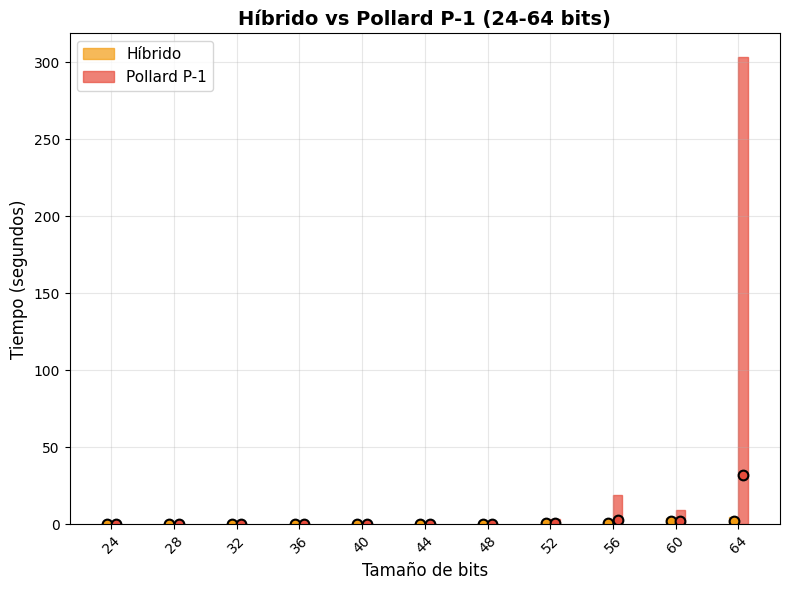

✅ Gráfico generado: Híbrido vs Pollard P-1 (24-64 bits)
   Tamaños incluidos: [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]



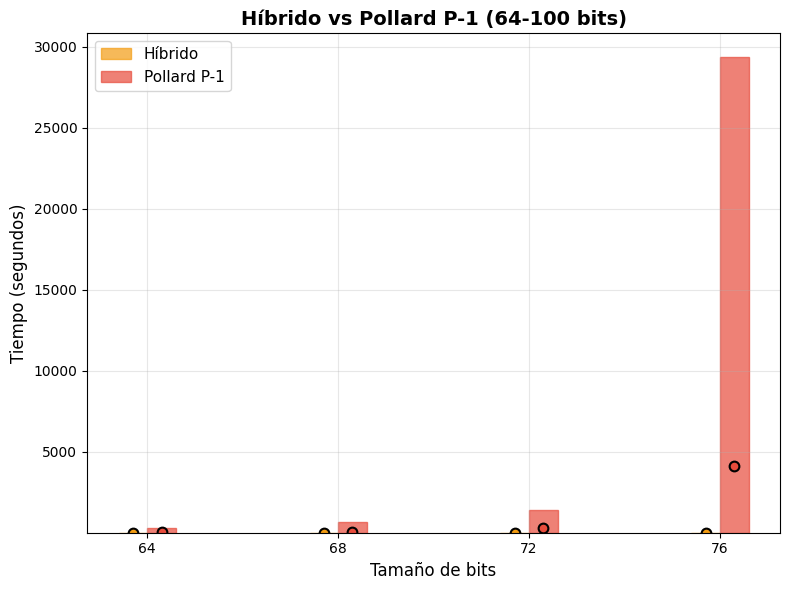

✅ Gráfico generado: Híbrido vs Pollard P-1 (64-100 bits)
   Tamaños incluidos: [64, 68, 72, 76]

Sin datos en rango 100-128 bits para Híbrido vs Pollard P-1

📈 Generando: Híbrido vs Criba Cuadrática


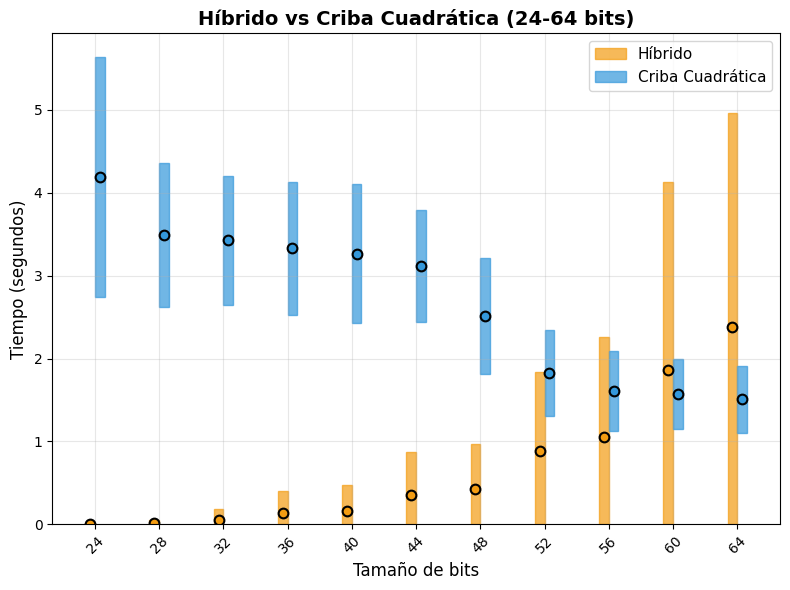

✅ Gráfico generado: Híbrido vs Criba Cuadrática (24-64 bits)
   Tamaños incluidos: [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]



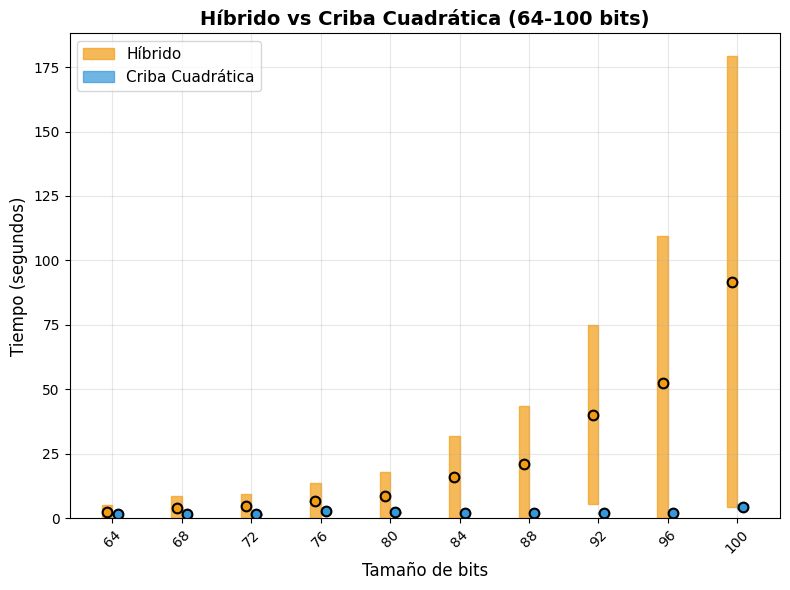

✅ Gráfico generado: Híbrido vs Criba Cuadrática (64-100 bits)
   Tamaños incluidos: [64, 68, 72, 76, 80, 84, 88, 92, 96, 100]



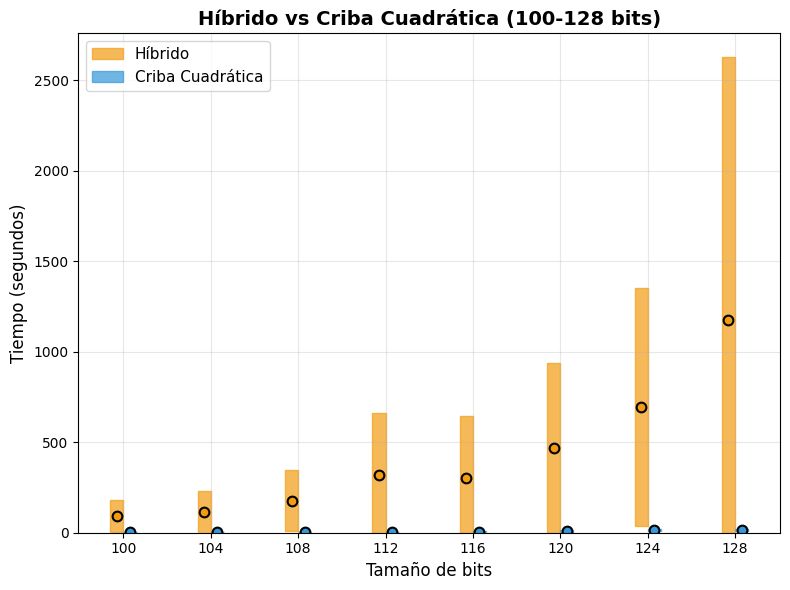

✅ Gráfico generado: Híbrido vs Criba Cuadrática (100-128 bits)
   Tamaños incluidos: [100, 104, 108, 112, 116, 120, 124, 128]


📈 Generando: Híbrido vs Lenstra ECM


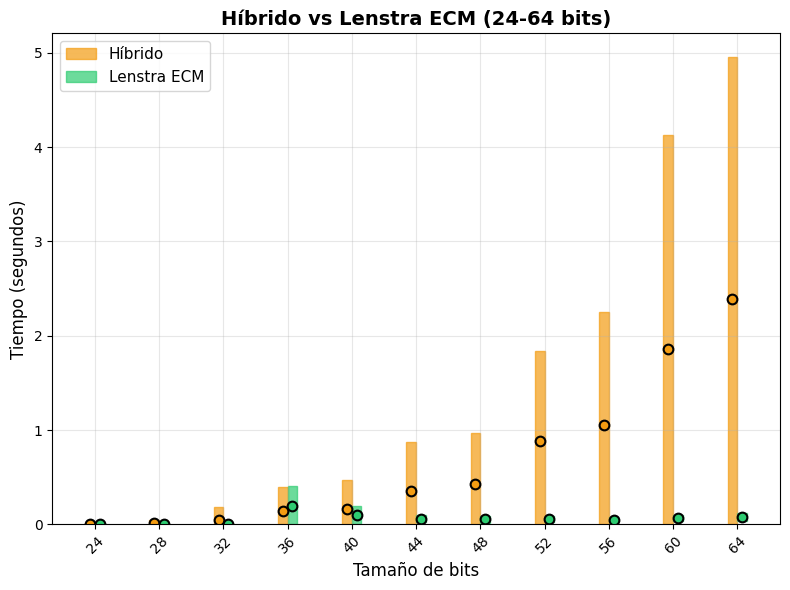

✅ Gráfico generado: Híbrido vs Lenstra ECM (24-64 bits)
   Tamaños incluidos: [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]



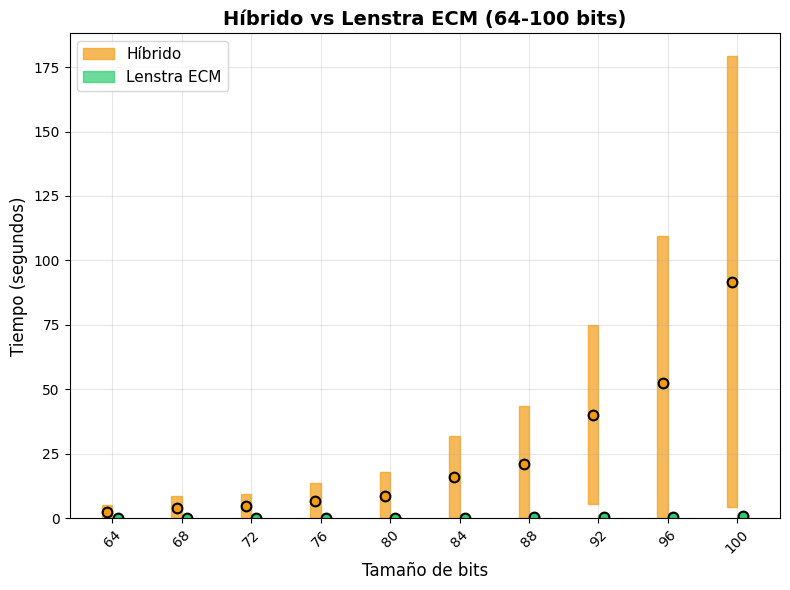

✅ Gráfico generado: Híbrido vs Lenstra ECM (64-100 bits)
   Tamaños incluidos: [64, 68, 72, 76, 80, 84, 88, 92, 96, 100]



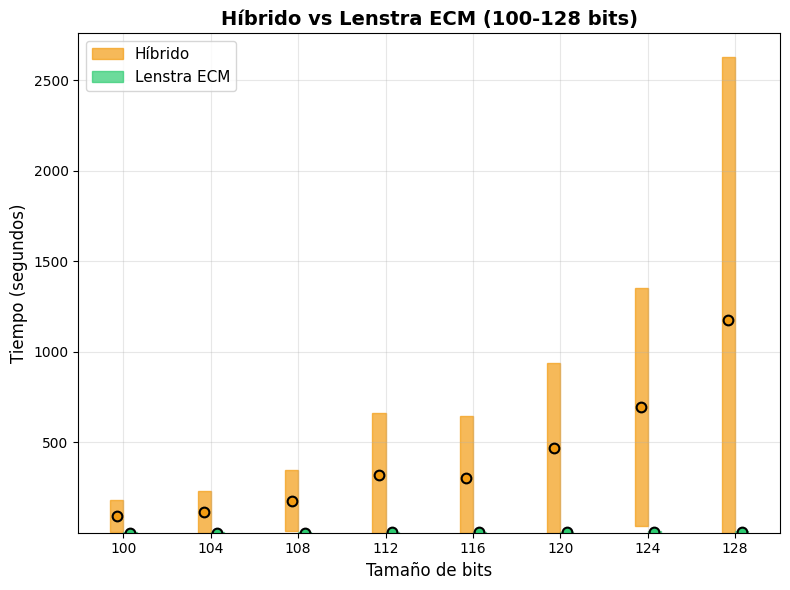

✅ Gráfico generado: Híbrido vs Lenstra ECM (100-128 bits)
   Tamaños incluidos: [100, 104, 108, 112, 116, 120, 124, 128]


📈 Generando: Híbrido vs Novale
No hay datos comparables entre Híbrido y Novale

📈 Generando: Híbrido vs Pollard Rho


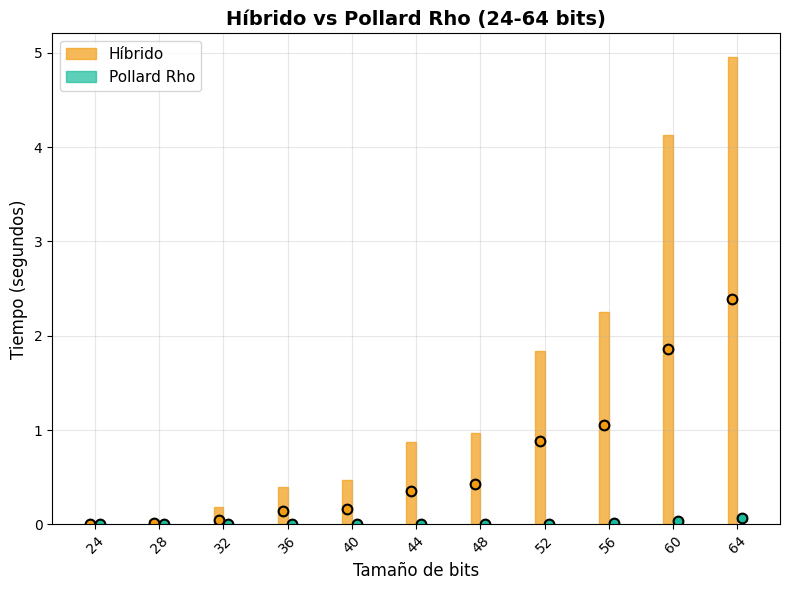

✅ Gráfico generado: Híbrido vs Pollard Rho (24-64 bits)
   Tamaños incluidos: [24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]



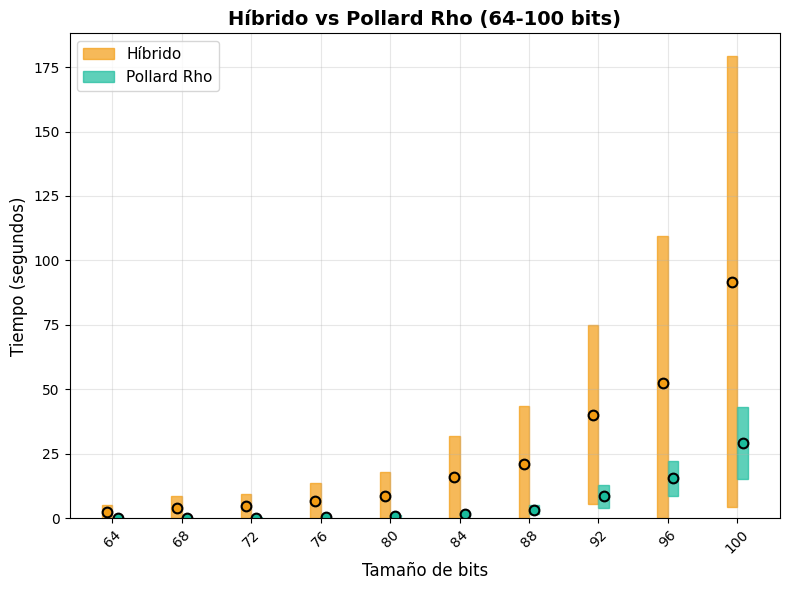

✅ Gráfico generado: Híbrido vs Pollard Rho (64-100 bits)
   Tamaños incluidos: [64, 68, 72, 76, 80, 84, 88, 92, 96, 100]



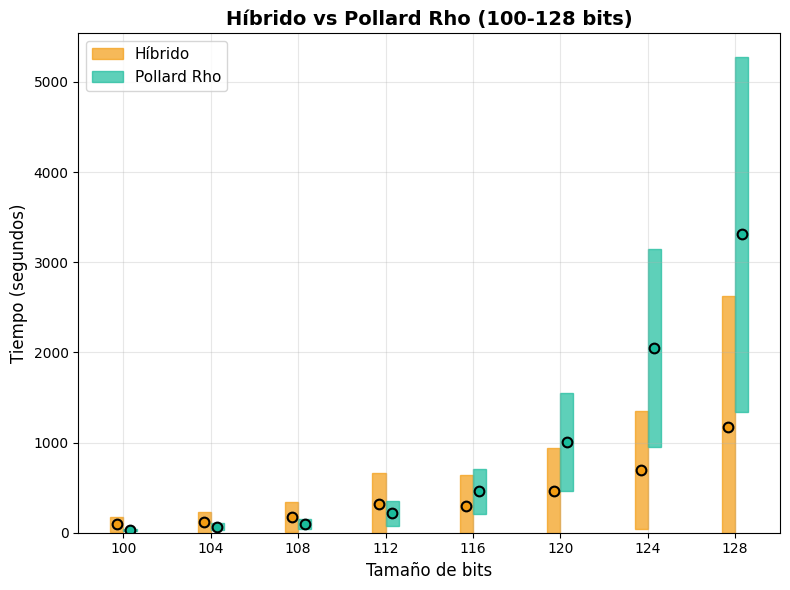

✅ Gráfico generado: Híbrido vs Pollard Rho (100-128 bits)
   Tamaños incluidos: [100, 104, 108, 112, 116, 120, 124, 128]


ESTADÍSTICAS DE RENDIMIENTO POR MÉTODO Y TAMAÑO

Tamaño: 24 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
---------------------------------------------------------------------------
Híbrido              100   3.340e-03    1.010e-02    [0.000e+00, 1.344e-02]
Pollard P-1          98    5.104e-05    2.213e-04    [0.000e+00, 2.723e-04]
Criba Cuadrática     99    4.194e+00    1.448e+00    [2.745e+00, 5.642e+00]
Lenstra ECM          100   5.545e-04    6.050e-04    [0.000e+00, 1.160e-03]
Pollard Rho          100   3.506e-05    2.046e-04    [0.000e+00, 2.397e-04]

Tamaño: 28 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
-----------------------------------------------

In [70]:
stats = analyze_factorization_performance(files)

Cargados 3300 registros de resultados_debiles.txt
Cargados 3300 registros de resultados_criba_cuadrática_debiles.txt
Analizando claves en 100 registros distribuidos de 6600 total...
Claves encontradas: ['bit_size', 'criba_cuadratica_factor', 'criba_cuadratica_time', 'hibrido_factor', 'hibrido_time', 'lenstra_factor', 'lenstra_time', 'number', 'pollard_factor', 'pollard_time']
Claves de tiempo: ['hibrido_time', 'pollard_time', 'lenstra_time', 'criba_cuadratica_time']
Claves de factor: ['pollard_factor', 'hibrido_factor', 'criba_cuadratica_factor', 'lenstra_factor']
Método detectado: Criba Cuadrática (tiempo: criba_cuadratica_time, factor: criba_cuadratica_factor)
Método detectado: Híbrido (tiempo: hibrido_time, factor: hibrido_factor)
Método detectado: Lenstra ECM (tiempo: lenstra_time, factor: lenstra_factor)
Método detectado: Pollard Rho (tiempo: pollard_time, factor: pollard_factor)

Total de métodos detectados: 4
✅ Método base 'Híbrido' encontrado y priorizado

RESUMEN DE DATOS CARG

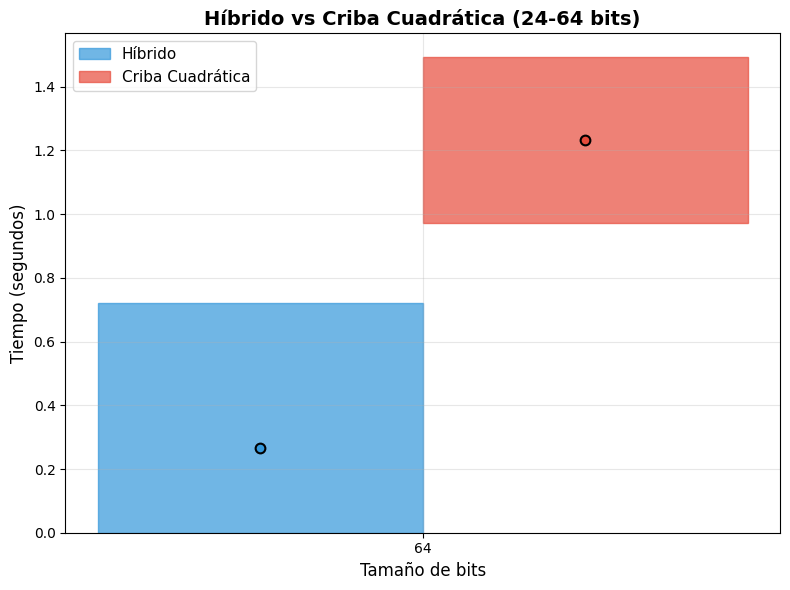

✅ Gráfico generado: Híbrido vs Criba Cuadrática (24-64 bits)
   Tamaños incluidos: [64]



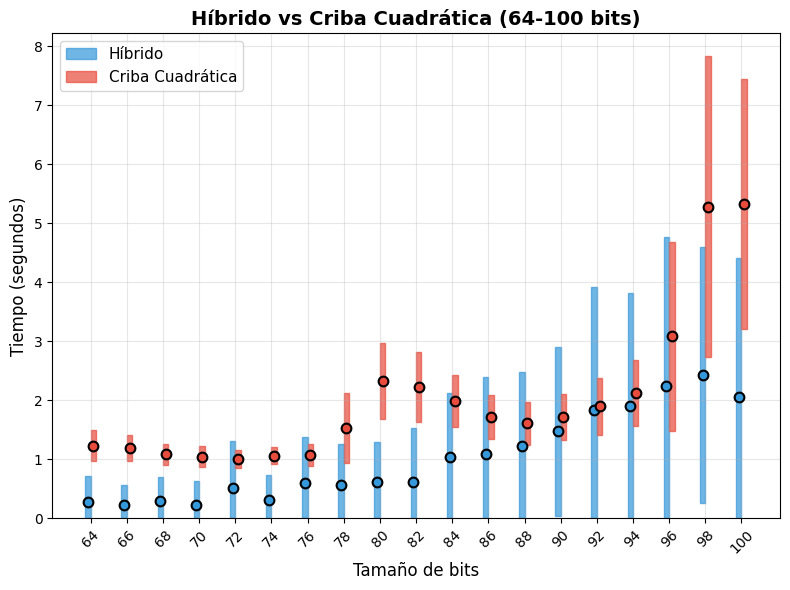

✅ Gráfico generado: Híbrido vs Criba Cuadrática (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



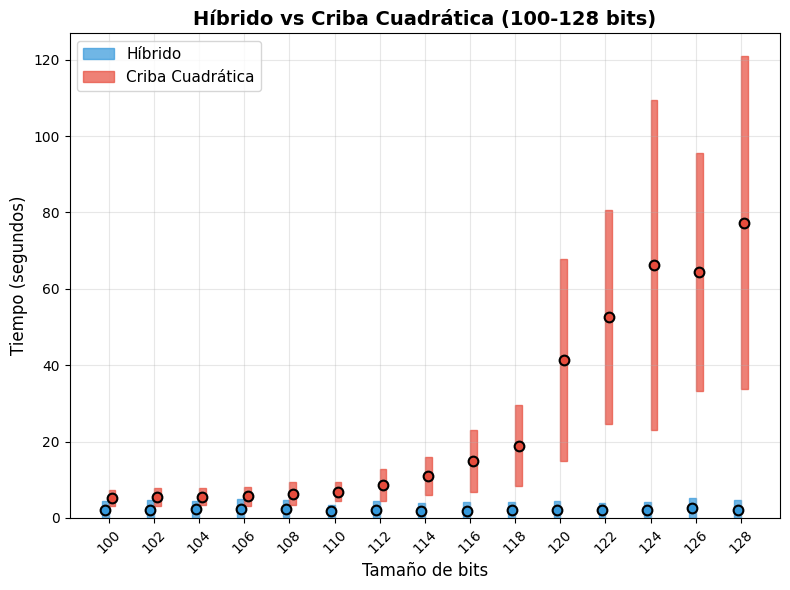

✅ Gráfico generado: Híbrido vs Criba Cuadrática (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


📈 Generando: Híbrido vs Lenstra ECM


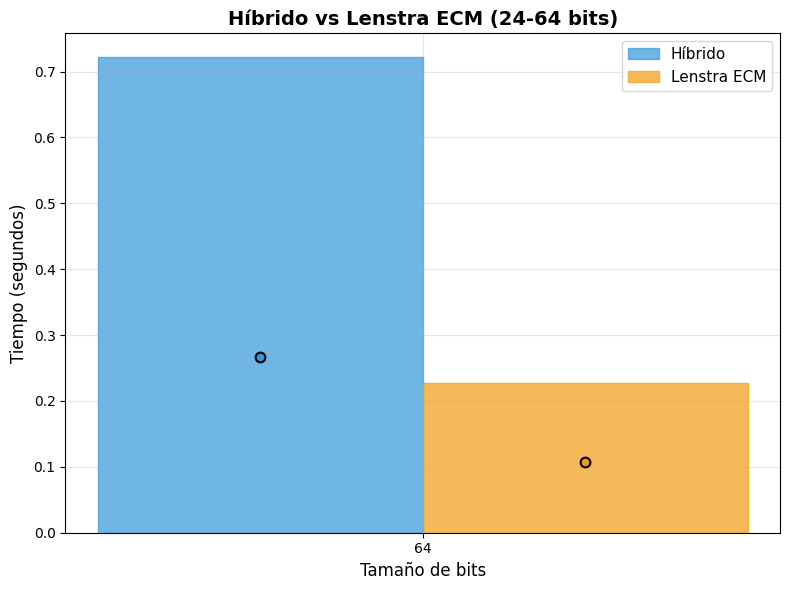

✅ Gráfico generado: Híbrido vs Lenstra ECM (24-64 bits)
   Tamaños incluidos: [64]



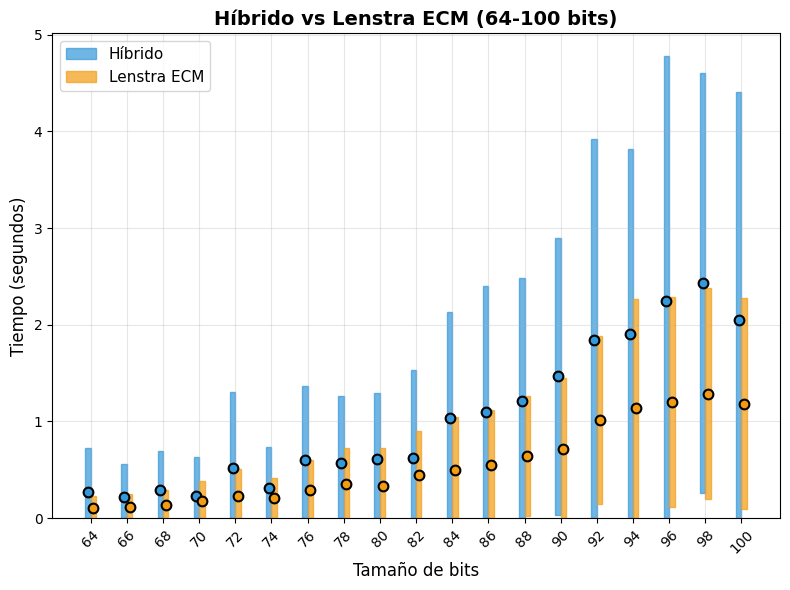

✅ Gráfico generado: Híbrido vs Lenstra ECM (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



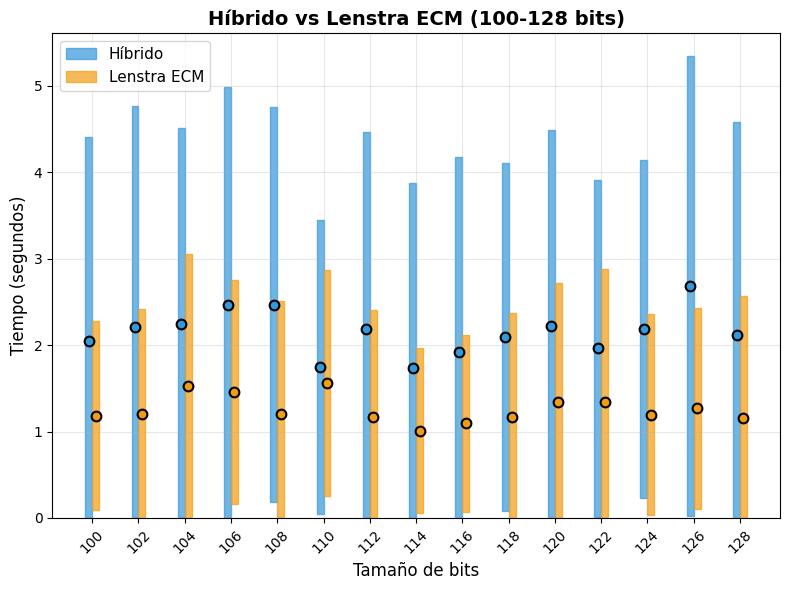

✅ Gráfico generado: Híbrido vs Lenstra ECM (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


📈 Generando: Híbrido vs Pollard Rho


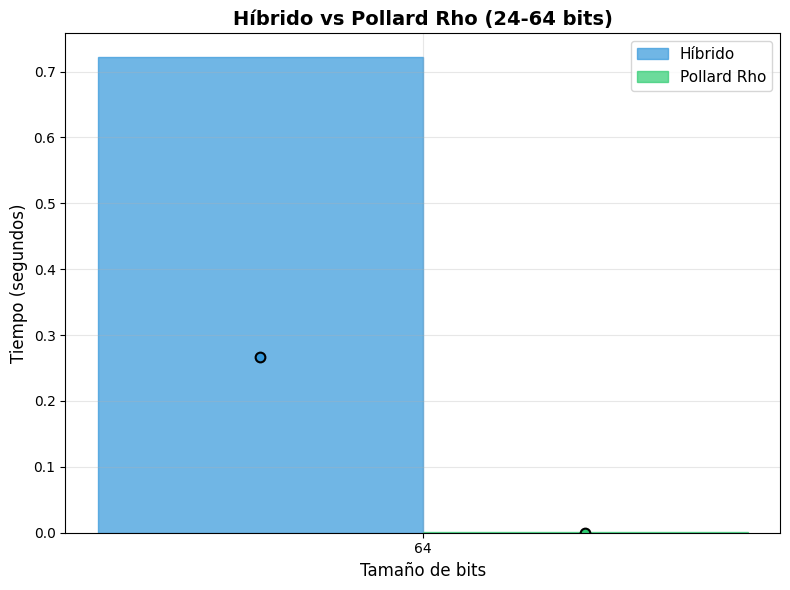

✅ Gráfico generado: Híbrido vs Pollard Rho (24-64 bits)
   Tamaños incluidos: [64]



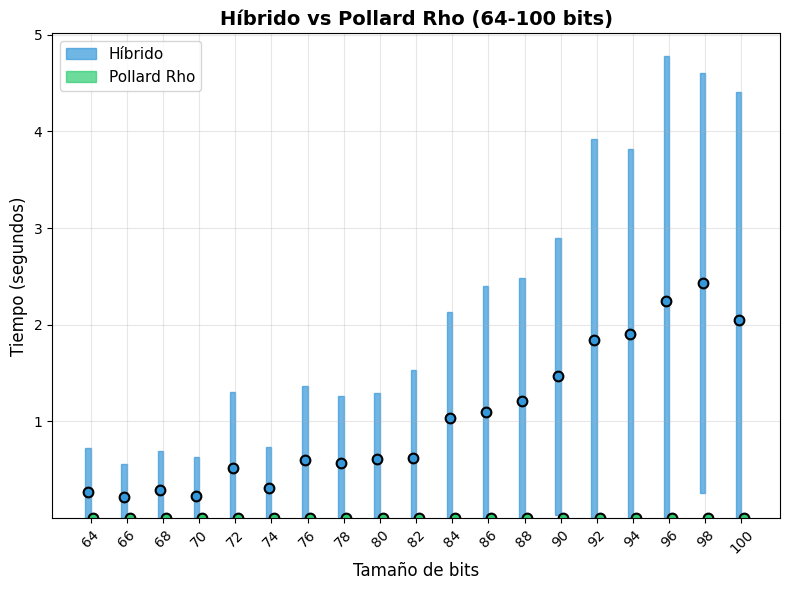

✅ Gráfico generado: Híbrido vs Pollard Rho (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



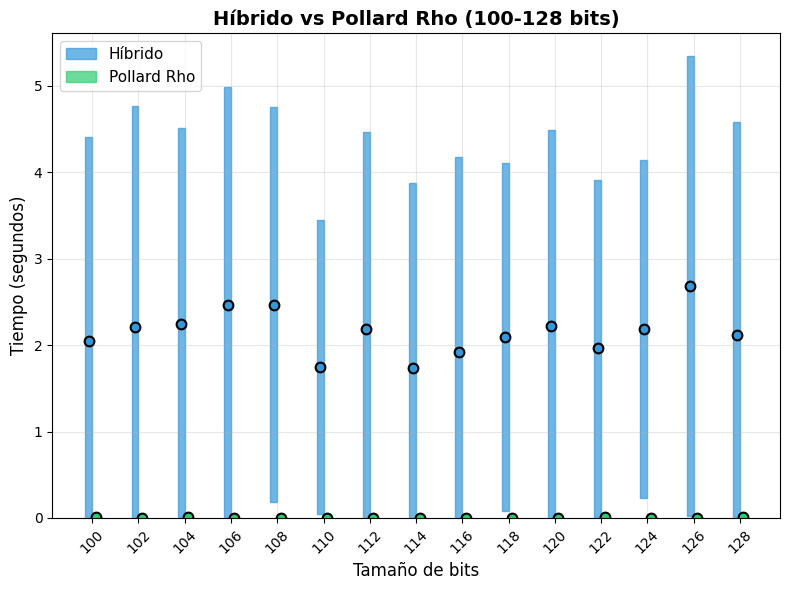

✅ Gráfico generado: Híbrido vs Pollard Rho (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


ESTADÍSTICAS DE RENDIMIENTO POR MÉTODO Y TAMAÑO

Tamaño: 64 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
---------------------------------------------------------------------------
Híbrido              100   2.667e-01    4.552e-01    [0.000e+00, 7.219e-01]
Criba Cuadrática     100   1.232e+00    2.605e-01    [9.720e-01, 1.493e+00]
Lenstra ECM          100   1.071e-01    1.204e-01    [0.000e+00, 2.276e-01]
Pollard Rho          100   1.792e-04    3.845e-04    [0.000e+00, 5.638e-04]

Tamaño: 66 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
---------------------------------------------------------------------------
Híbrido     

In [71]:
stats = analyze_factorization_performance(['resultados_debiles.txt','resultados_criba_cuadrática_debiles.txt'])

In [1]:
if __name__ == "__main__":
    files = ['resultados_debiles.txt', 'resultados_sinhibrido.txt', 'resultados_criba_cuadrática.txt']
    
    try:
        df, agg_df, fig = analyze_factorization_times(files, custom_labels={'pollard_time': 'Pollard Rho'}, exclude_methods=['novale_time','IMP_lenstra_time', 'IMP_pollard_rho_time'])
        plt.show()
        print("Analysis complete!")
        display_summary_statistics(df, agg_df)
    except FileNotFoundError as e:
        print(f"Error: Could not find file. {e}")
    except Exception as e:
        print(f"Error during analysis: {e}")

Error during analysis: name 'analyze_factorization_times' is not defined


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings('ignore')

def analyze_factorization_performance(file_paths: Union[str, List[str]], 
                                     figsize: tuple = (8, 6),
                                     save_plots: bool = False,
                                     output_dir: str = "plots",
                                     base_method: str = "hibrido") -> Dict:
    """
    Analiza el rendimiento de algoritmos de factorización y genera gráficas comparativas.
    
    La función compara tiempos de ejecución entre métodos usando barras de error que 
    representan el rango [media - desviación estándar, media + desviación estándar].
    
    Parámetros:
    -----------
    file_paths : str o List[str]
        Ruta(s) a archivo(s) con datos de factorización
    figsize : tuple, opcional
        Tamaño de las figuras (ancho, alto)
    save_plots : bool, opcional
        Si True, guarda las gráficas en archivos PNG
    output_dir : str, opcional
        Directorio donde guardar las gráficas si save_plots=True
    base_method : str, opcional
        Nombre del método a usar como referencia para comparaciones (por defecto "hibrido")
        
    Retorna:
    --------
    Dict con estadísticas calculadas por tamaño de bits y método
    """
    
    # Convertir a lista si es string único
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    # Cargar y combinar datos de todos los archivos
    all_data = []
    for file_path in file_paths:
        data = _load_data_file(file_path)
        all_data.extend(data)
        print(f"Cargados {len(data)} registros de {file_path}")
    
    if not all_data:
        raise ValueError("No se encontraron datos válidos en los archivos")
    
    # Identificar métodos y calcular estadísticas
    methods = _identify_methods(all_data)
    
    # Reorganizar métodos para poner el método base primero
    methods = _prioritize_base_method(methods, base_method)
    
    statistics = _calculate_statistics(all_data, methods)
    
    # Mostrar resumen de datos
    _display_data_summary(statistics, methods)
    
    # Crear gráficas comparativas uno a uno
    if len(methods) < 2:
        print(f"\n⚠️  Solo se detectó 1 método ({methods[0]['name'] if methods else 'ninguno'})")
        print("No se pueden crear comparaciones con un solo método.")
    else:
        base_method_obj = methods[0]  # Primer método (ya organizado)
        other_methods = methods[1:]
        
        print(f"\nCreando comparaciones uno a uno:")
        print(f"🎯 Método base: '{base_method_obj['name']}'")
        print(f"📊 Comparando con: {[m['name'] for m in other_methods]}")
        
        # Comparaciones uno a uno
        for compare_method in other_methods:
            print(f"\n📈 Generando: {base_method_obj['name']} vs {compare_method['name']}")
            _create_pairwise_plot(statistics, base_method_obj, compare_method, 
                                 figsize, save_plots, output_dir)
    
    # Tabla de estadísticas
    _display_statistics_table(statistics, methods)
    
    return statistics

def _prioritize_base_method(methods: List[Dict], base_method_name: str) -> List[Dict]:
    """Reorganiza la lista de métodos para poner el método base primero."""
    
    # Buscar el método base (insensible a mayúsculas/minúsculas)
    base_method_obj = None
    other_methods = []
    
    for method in methods:
        # Comparar tanto el nombre original como el formateado
        method_key = method['time_key'].replace('_time', '').lower()
        if (method_key == base_method_name.lower() or 
            method['name'].lower() == base_method_name.lower()):
            base_method_obj = method
        else:
            other_methods.append(method)
    
    if base_method_obj:
        print(f"✅ Método base '{base_method_obj['name']}' encontrado y priorizado")
        return [base_method_obj] + other_methods
    else:
        print(f"⚠️  Método base '{base_method_name}' no encontrado")
        print(f"   Usando '{methods[0]['name']}' como método base por defecto")
        return methods

def _load_data_file(file_path: str) -> List[Dict]:
    """Carga datos desde un archivo con formato Python dict por línea."""
    data = []
    errors = 0
    
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, 1):
                line = line.strip()
                if line:
                    try:
                        # Convertir formato Python a JSON válido
                        json_line = line.replace("'", '"').replace("None", "null")
                        # Manejar sets de Python {1, 2, 3} -> [1, 2, 3]
                        json_line = _convert_python_sets_to_lists(json_line)
                        record = json.loads(json_line)
                        data.append(record)
                    except (json.JSONDecodeError, ValueError) as e:
                        errors += 1
                        if errors <= 5:  # Mostrar solo primeros 5 errores
                            print(f"Error línea {line_num}: {str(e)[:50]}...")
                        elif errors == 6:
                            print("... (más errores omitidos)")
                        continue
                        
    except FileNotFoundError:
        print(f"❌ Archivo no encontrado: {file_path}")
        return []
    except Exception as e:
        print(f"❌ Error leyendo {file_path}: {e}")
        return []
    
    if errors > 0:
        print(f"Total de líneas con errores: {errors}")
        if errors > len(data):
            print(f"⚠️  ADVERTENCIA: Más errores ({errors}) que registros válidos ({len(data)})")
    
    return data

def _convert_python_sets_to_lists(json_line: str) -> str:
    """Convierte sets de Python {1,2,3} a listas JSON [1,2,3]."""
    import re
    # Buscar patrones como {número, número, ...} incluyendo espacios y comas
    pattern = r'\{([0-9,\s]+)\}'
    
    def replace_set(match):
        numbers = match.group(1).strip()
        return f'[{numbers}]'
    
    return re.sub(pattern, replace_set, json_line)

def _identify_methods(data: List[Dict]) -> List[Dict]:
    """Identifica métodos buscando pares method_factor y method_time en TODOS los registros."""
    
    if not data:
        raise ValueError("No hay datos para analizar")
    
    # Colores para los métodos
    colors = ['#e74c3c', '#3498db', '#f39c12', "#064e24", '#9b59b6', 
              "#00ffcc", '#e67e22', '#34495e', '#e91e63', '#795548']
    
    # Analizar claves en TODOS los registros para detectar todos los métodos
    all_keys = set()
    sample_size = min(100, len(data))  # Analizar hasta 100 registros
    step = max(1, len(data) // sample_size)  # Tomar muestras distribuidas
    
    print(f"Analizando claves en {sample_size} registros distribuidos de {len(data)} total...")
    
    for i in range(0, len(data), step):
        if len(all_keys) > 50:  # Limitar para eficiencia
            break
        all_keys.update(data[i].keys())
    
    print(f"Claves encontradas: {sorted(all_keys)}")
    
    # Encontrar métodos buscando pares method_time y method_factor
    time_keys = [key for key in all_keys if key.endswith('_time')]
    factor_keys = [key for key in all_keys if key.endswith('_factor')]
    
    print(f"Claves de tiempo: {time_keys}")
    print(f"Claves de factor: {factor_keys}")
    
    # Emparejar métodos
    methods = []
    used_methods = set()
    
    for time_key in sorted(time_keys):
        method_name = time_key.replace('_time', '')
        factor_key = f"{method_name}_factor"
        
        if factor_key in factor_keys and method_name not in used_methods:
            method_info = {
                'name': _format_method_name(method_name),
                'short_name': _generate_short_name(method_name),
                'time_key': time_key,
                'factor_key': factor_key,
                'color': colors[len(methods) % len(colors)]
            }
            methods.append(method_info)
            used_methods.add(method_name)
            print(f"Método detectado: {method_info['name']} (tiempo: {time_key}, factor: {factor_key})")
    
    if not methods:
        raise ValueError("No se encontraron pares válidos de method_time y method_factor")
    
    print(f"\nTotal de métodos detectados: {len(methods)}")
    return methods

def _format_method_name(method_name: str) -> str:
    """Convierte nombre del método a formato legible."""
    name_mapping = {
        'hibrido': 'Híbrido',
        'novale': 'Novale',
        'pollard': 'Pollard Rho',
        'lenstra': 'Lenstra ECM',
        'criba_cuadratica': 'Criba Cuadrática',
        'trial_division': 'División de Prueba',
        'fermat': 'Fermat',
        'brent': 'Brent',
        '2': 'Método 2',  # Para casos como "2_time"
        'IMP_pollard_rho': 'Pollard Rho',
        'IMP_lenstra': 'Lenstra ECM',
        'IMP_pollardp-1':'Pollard P-1'
    }
    
    if method_name in name_mapping:
        return name_mapping[method_name]
    
    # Limpiar prefijos IMP_
    clean_name = method_name.replace('IMP_', '').replace('_', ' ').title()
    return clean_name

def _generate_short_name(method_name: str) -> str:
    """Genera nombre corto para el método."""
    short_mapping = {
        'hibrido': 'HYB',
        'novale': 'NOV',
        'pollard': 'POL',
        'lenstra': 'LEN',
        'criba_cuadratica': 'CQ',
        'trial_division': 'TD',
        'fermat': 'FER',
        'brent': 'BRE',
        '2': 'M2',
        'IMP_pollard_rho': 'POL',
        'IMP_lenstra': 'LEN',
        'IMP_pollardp-1':'P-1'
    }
    
    if method_name in short_mapping:
        return short_mapping[method_name]
    
    # Limpiar y abreviar
    clean_name = method_name.replace('IMP_', '')
    return clean_name[:3].upper()

def _calculate_statistics(data: List[Dict], methods: List[Dict]) -> Dict:
    """Calcula estadísticas por tamaño de bits y método."""
    bit_sizes = sorted(set(record['bit_size'] for record in data))
    statistics = {}
    
    for bit_size in bit_sizes:
        subset = [r for r in data if r['bit_size'] == bit_size]
        statistics[bit_size] = {}
        
        for method in methods:
            times = []
            for record in subset:
                if method['time_key'] in record and method['factor_key'] in record:
                    time_val = record[method['time_key']]
                    factor_val = record[method['factor_key']]
                    
                    # Solo incluir si el factor no es None (método fue exitoso)
                    if factor_val is not None:
                        times.append(time_val)
            
            if times:  # Solo procesar si hay datos válidos
                mean_time = np.mean(times)
                std_time = np.std(times, ddof=1) if len(times) > 1 else 0
                
                # Calcular rangos manteniendo la media centrada
                min_range = mean_time - std_time
                if min_range < 0:
                    min_range = 0
                max_range = mean_time + std_time
                
                statistics[bit_size][method['name']] = {
                    'mean': mean_time,
                    'std': std_time,
                    'min_range': min_range,
                    'max_range': max_range,
                    'count': len(times),
                    'times': times
                }
    
    return statistics

def _display_data_summary(statistics: Dict, methods: List[Dict]):
    """Muestra resumen de los datos cargados."""
    bit_sizes = sorted(statistics.keys())
    total_records = sum(
        sum(stats[method['name']]['count'] for method in methods if method['name'] in stats)
        for stats in statistics.values()
    )
    
    print(f"\n{'='*60}")
    print("RESUMEN DE DATOS CARGADOS")
    print(f"{'='*60}")
    print(f"Total de registros válidos: {total_records}")
    print(f"Tamaños de bits: {min(bit_sizes)} - {max(bit_sizes)} ({len(bit_sizes)} grupos)")
    print(f"Métodos detectados: {[m['name'] for m in methods]}")
    print(f"{'='*60}\n")

def _create_pairwise_plot(statistics: Dict, method1: Dict, method2: Dict, 
                         figsize: tuple, save_plots: bool, output_dir: str):
    """Crea 3 gráficas separadas de comparación entre dos métodos específicos por rangos."""
    
    bit_sizes = sorted(statistics.keys())
    
    # Filtrar tamaños donde ambos métodos tienen datos
    valid_sizes = [bs for bs in bit_sizes 
                   if method1['name'] in statistics[bs] and method2['name'] in statistics[bs]]
    
    if not valid_sizes:
        print(f"No hay datos comparables entre {method1['name']} y {method2['name']}")
        return
    
    # Definir los 3 rangos
    ranges = [
        #{'name': '24-64 bits', 'min': 24, 'max': 64, 'suffix': '_small'},
        #{'name': '64-100 bits', 'min': 64, 'max': 100, 'suffix': '_medium'}, 
        {'name': '64-128 bits', 'min': 64, 'max': 128, 'suffix': '_large'}
    ]
    
    # Crear 3 gráficos separados
    for range_info in ranges:
        # Filtrar datos para este rango
        range_sizes = [bs for bs in valid_sizes 
                      if range_info['min'] <= bs <= range_info['max']]
        
        if not range_sizes:
            print(f"Sin datos en rango {range_info['name']} para {method1['name']} vs {method2['name']}")
            continue
        
        # Crear figura individual
        fig, ax = plt.subplots(figsize=figsize)
        
        x_positions = np.arange(len(range_sizes))
        width = 0.15
        
        # Extraer datos para este rango
        data1 = [statistics[bs][method1['name']] for bs in range_sizes]
        data2 = [statistics[bs][method2['name']] for bs in range_sizes]
        
        # Calcular posiciones y alturas de las barras de rango
        mins1 = [d['min_range'] for d in data1]
        maxs1 = [d['max_range'] for d in data1]
        heights1 = [max_val - min_val for min_val, max_val in zip(mins1, maxs1)]
        means1 = [d['mean'] for d in data1]
        
        mins2 = [d['min_range'] for d in data2]
        maxs2 = [d['max_range'] for d in data2]
        heights2 = [max_val - min_val for min_val, max_val in zip(mins2, maxs2)]
        means2 = [d['mean'] for d in data2]
        
        # Crear barras de rango (desde min_range hasta max_range)
        bars1 = ax.bar(x_positions - width/2, heights1, width, 
                       bottom=mins1, label=method1['name'], 
                       color=method1['color'], alpha=0.7, 
                       edgecolor=method1['color'], linewidth=1)
        
        bars2 = ax.bar(x_positions + width/2, heights2, width,
                       bottom=mins2, label=method2['name'], 
                       color=method2['color'], alpha=0.7, 
                       edgecolor=method2['color'], linewidth=1)
        
        # Añadir puntos para marcar la media dentro de cada barra
        for i, (x, mean1, mean2) in enumerate(zip(x_positions, means1, means2)):
            ax.plot(x - width/2, mean1, 'o', color=method1['color'], markersize=7, 
                   markeredgecolor='black', markeredgewidth=1.5)
            ax.plot(x + width/2, mean2, 'o', color=method2['color'], markersize=7, 
                   markeredgecolor='black', markeredgewidth=1.5)
        
        # Configurar el gráfico
        ax.set_xlabel('Tamaño de bits', fontsize=12)
        ax.set_ylabel('Tiempo (segundos)', fontsize=12)
        ax.set_title(f'{method1["name"]} vs {method2["name"]} ({range_info["name"]})', 
                    fontsize=14, fontweight='bold')
        
        ax.set_xticks(x_positions)
        ax.set_xticklabels(range_sizes, rotation=45 if len(range_sizes) > 8 else 0)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_plots:
            Path(output_dir).mkdir(exist_ok=True)
            filename = f"{method1['short_name']}_vs_{method2['short_name']}{range_info['suffix']}.png"
            plt.savefig(Path(output_dir) / filename, dpi=300, bbox_inches='tight')
            print(f"Gráfica guardada: {filename}")
        
        plt.show()
        
        print(f"✅ Gráfico generado: {method1['name']} vs {method2['name']} ({range_info['name']})")
        print(f"   Tamaños incluidos: {range_sizes}")
        print()

def _display_statistics_table(statistics: Dict, methods: List[Dict]):
    """Muestra tabla de estadísticas descriptivas."""
    
    print(f"\n{'='*80}")
    print("ESTADÍSTICAS DE RENDIMIENTO POR MÉTODO Y TAMAÑO")
    print(f"{'='*80}")
    
    for bit_size in sorted(statistics.keys()):
        print(f"\nTamaño: {bit_size} bits")
        print("-" * 75)
        print(f"{'Método':<20} {'N':<5} {'Media (s)':<12} {'Desv.Est':<12} {'Rango [μ-σ, μ+σ]'}")
        print("-" * 75)
        
        for method in methods:
            if method['name'] in statistics[bit_size]:
                stats = statistics[bit_size][method['name']]
                rango = f"[{stats['min_range']:.3e}, {stats['max_range']:.3e}]"
                print(f"{method['name']:<20} {stats['count']:<5} {stats['mean']:<12.3e} "
                      f"{stats['std']:<12.3e} {rango}")

def debug_file_methods(file_paths: Union[str, List[str]]) -> None:
    """
    Función de depuración para ver qué métodos se detectan en cada archivo.
    Útil para solucionar problemas de detección de métodos.
    """
    if isinstance(file_paths, str):
        file_paths = [file_paths]
    
    print("DEPURACIÓN: Analizando métodos por archivo")
    print("=" * 50)
    
    all_methods = set()
    
    for file_path in file_paths:
        print(f"\n📁 Archivo: {file_path}")
        print("-" * 30)
        
        data = _load_data_file(file_path)
        if not data:
            print("❌ No se pudieron cargar datos")
            continue
            
        print(f"✅ Registros cargados: {len(data)}")
        
        # Analizar claves en algunos registros
        file_keys = set()
        sample_size = min(20, len(data))
        for i in range(0, len(data), max(1, len(data) // sample_size)):
            file_keys.update(data[i].keys())
        
        time_keys = [k for k in file_keys if k.endswith('_time')]
        factor_keys = [k for k in file_keys if k.endswith('_factor')]
        
        print(f"⏱️  Claves de tiempo: {time_keys}")
        print(f"🔢 Claves de factor: {factor_keys}")
        
        # Detectar métodos
        file_methods = []
        for time_key in time_keys:
            method_name = time_key.replace('_time', '')
            factor_key = f"{method_name}_factor"
            if factor_key in factor_keys:
                formatted_name = _format_method_name(method_name)
                file_methods.append(formatted_name)
                all_methods.add(formatted_name)
        
        if file_methods:
            print(f"🎯 Métodos detectados: {file_methods}")
        else:
            print("⚠️  No se detectaron métodos válidos")
    
    print(f"\n{'='*50}")
    print(f"RESUMEN TOTAL:")
    print(f"Métodos únicos detectados: {sorted(all_methods)}")
    print(f"Total de métodos: {len(all_methods)}")
    
    if len(all_methods) < 2:
        print("\n⚠️  ADVERTENCIA: Se necesitan al menos 2 métodos para comparaciones")
        print("   Verifica que tus archivos contengan múltiples algoritmos")

def quick_factorization_analysis(file_paths: Union[str, List[str]], 
                               base_method: str = "hibrido") -> Dict:
    """
    Análisis rápido con configuración estándar.
    
    Parámetros:
    -----------
    file_paths : str o List[str]
        Ruta(s) a archivo(s) con datos de factorización
    base_method : str, opcional
        Método a usar como referencia (por defecto "hibrido")
    """
    return analyze_factorization_performance(file_paths, figsize=(6, 6), base_method=base_method)

def export_statistics_to_csv(statistics: Dict, methods: List[Dict], 
                           filename: str = "factorization_stats.csv") -> str:
    """Exporta estadísticas a archivo CSV."""
    
    rows = []
    for bit_size in sorted(statistics.keys()):
        for method in methods:
            if method['name'] in statistics[bit_size]:
                stats = statistics[bit_size][method['name']]
                rows.append({
                    'bit_size': bit_size,
                    'method': method['name'],
                    'count': stats['count'],
                    'mean_time': stats['mean'],
                    'std_time': stats['std'],
                    'min_range': stats['min_range'],
                    'max_range': stats['max_range']
                })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Estadísticas exportadas a: {filename}")
    return filename

# EJEMPLOS DE USO ACTUALIZADOS:
"""
EJEMPLOS DE USO:

1. Análisis básico (Híbrido como método base por defecto):
   stats = quick_factorization_analysis(["file1.txt", "file2.txt", "file3.txt"])

2. Análisis con método base específico:
   stats = quick_factorization_analysis(["file1.txt", "file2.txt"], base_method="pollard")

3. Análisis completo con configuración personalizada:
   stats = analyze_factorization_performance(
       file_paths=["file1.txt", "file2.txt", "file3.txt"],
       base_method="hibrido",  # Método de referencia
       figsize=(12, 8),
       save_plots=True,
       output_dir="resultados_hibrido"
   )

4. Depuración previa:
   debug_file_methods(["file1.txt", "file2.txt", "file3.txt"])

COMPARACIONES GENERADAS (con tus archivos):
- Híbrido vs Novale
- Híbrido vs Pollard Rho  
- Híbrido vs Lenstra ECM
- Híbrido vs Criba Cuadrática

NOTAS:
- El método base siempre aparece primero en las comparaciones
- Si no se encuentra el método base especificado, usa el primer método detectado
- Usa base_method="criba_cuadratica" si quieres Criba Cuadrática como referencia
"""

'\nEJEMPLOS DE USO:\n\n1. Análisis básico (Híbrido como método base por defecto):\n   stats = quick_factorization_analysis(["file1.txt", "file2.txt", "file3.txt"])\n\n2. Análisis con método base específico:\n   stats = quick_factorization_analysis(["file1.txt", "file2.txt"], base_method="pollard")\n\n3. Análisis completo con configuración personalizada:\n   stats = analyze_factorization_performance(\n       file_paths=["file1.txt", "file2.txt", "file3.txt"],\n       base_method="hibrido",  # Método de referencia\n       figsize=(12, 8),\n       save_plots=True,\n       output_dir="resultados_hibrido"\n   )\n\n4. Depuración previa:\n   debug_file_methods(["file1.txt", "file2.txt", "file3.txt"])\n\nCOMPARACIONES GENERADAS (con tus archivos):\n- Híbrido vs Novale\n- Híbrido vs Pollard Rho  \n- Híbrido vs Lenstra ECM\n- Híbrido vs Criba Cuadrática\n\nNOTAS:\n- El método base siempre aparece primero en las comparaciones\n- Si no se encuentra el método base especificado, usa el primer método

Cargados 3300 registros de resultados_debilesv2.txt
Analizando claves en 100 registros distribuidos de 3300 total...
Claves encontradas: ['bit_size', 'cc_factor', 'cc_time', 'hibrido_factor', 'hibrido_time', 'lenstra_factor', 'lenstra_time', 'number', 'pollard_factor', 'pollard_time']
Claves de tiempo: ['hibrido_time', 'pollard_time', 'cc_time', 'lenstra_time']
Claves de factor: ['pollard_factor', 'hibrido_factor', 'lenstra_factor', 'cc_factor']
Método detectado: Cc (tiempo: cc_time, factor: cc_factor)
Método detectado: Híbrido (tiempo: hibrido_time, factor: hibrido_factor)
Método detectado: Lenstra ECM (tiempo: lenstra_time, factor: lenstra_factor)
Método detectado: Pollard Rho (tiempo: pollard_time, factor: pollard_factor)

Total de métodos detectados: 4
✅ Método base 'Híbrido' encontrado y priorizado

RESUMEN DE DATOS CARGADOS
Total de registros válidos: 13200
Tamaños de bits: 64 - 128 (33 grupos)
Métodos detectados: ['Híbrido', 'Cc', 'Lenstra ECM', 'Pollard Rho']


Creando comparac

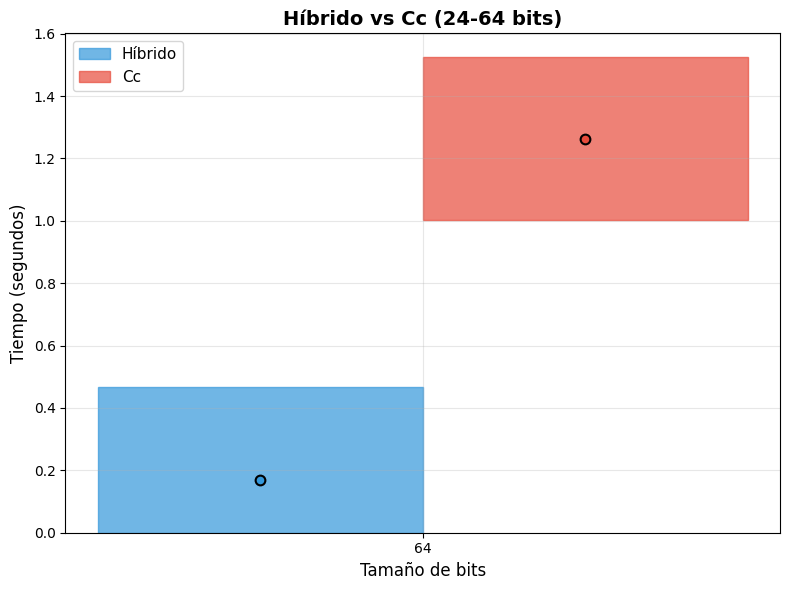

✅ Gráfico generado: Híbrido vs Cc (24-64 bits)
   Tamaños incluidos: [64]



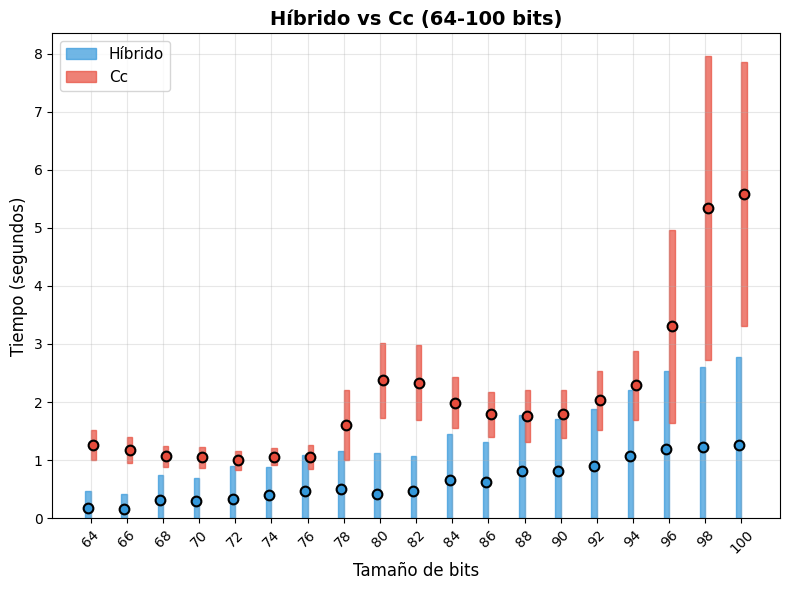

✅ Gráfico generado: Híbrido vs Cc (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



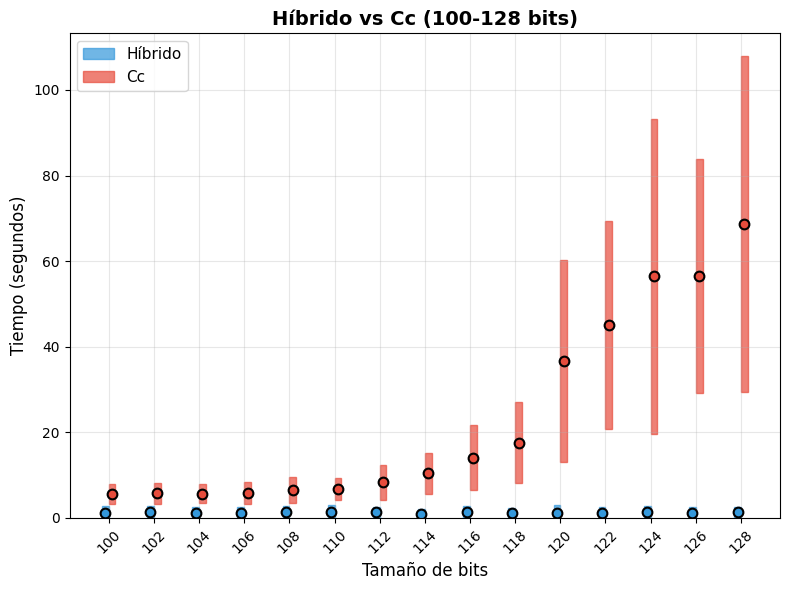

✅ Gráfico generado: Híbrido vs Cc (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


📈 Generando: Híbrido vs Lenstra ECM


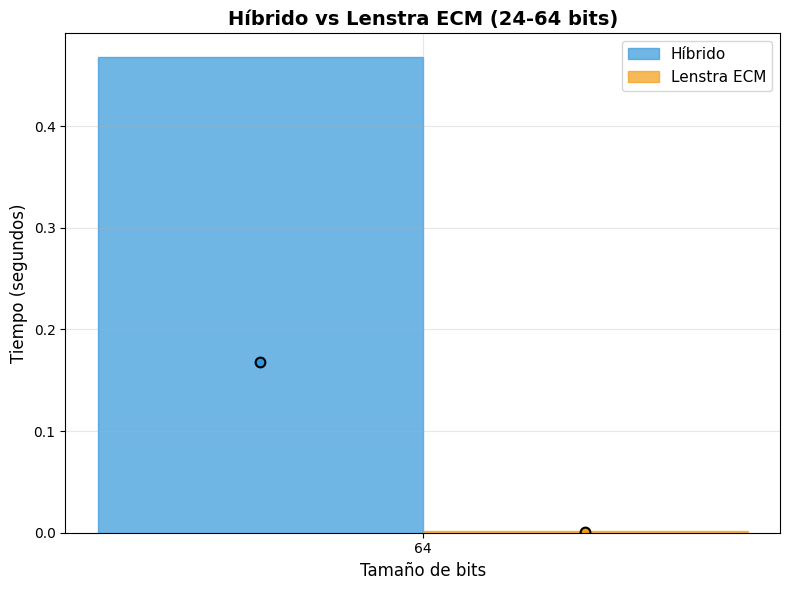

✅ Gráfico generado: Híbrido vs Lenstra ECM (24-64 bits)
   Tamaños incluidos: [64]



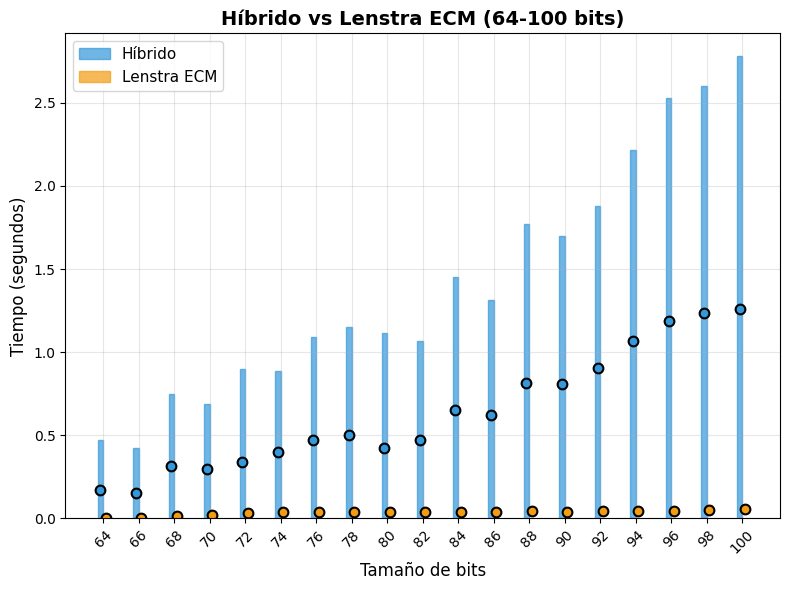

✅ Gráfico generado: Híbrido vs Lenstra ECM (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



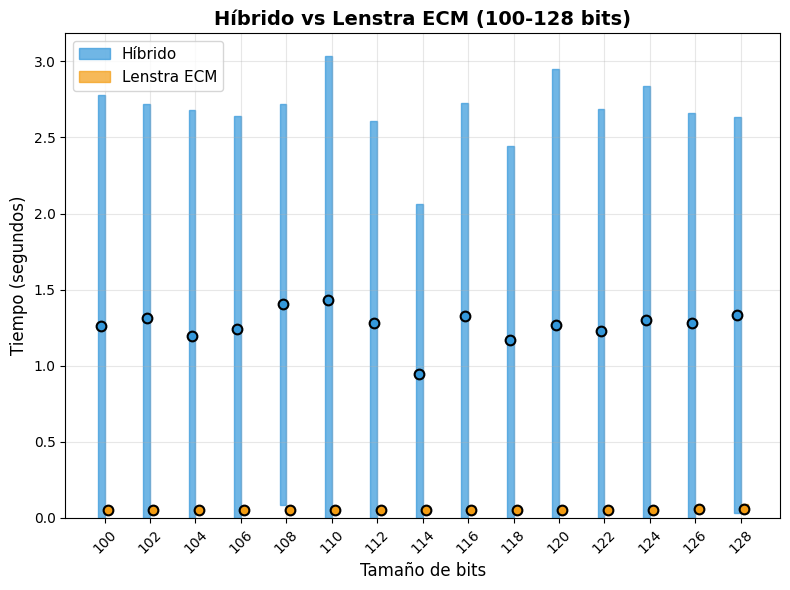

✅ Gráfico generado: Híbrido vs Lenstra ECM (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


📈 Generando: Híbrido vs Pollard Rho


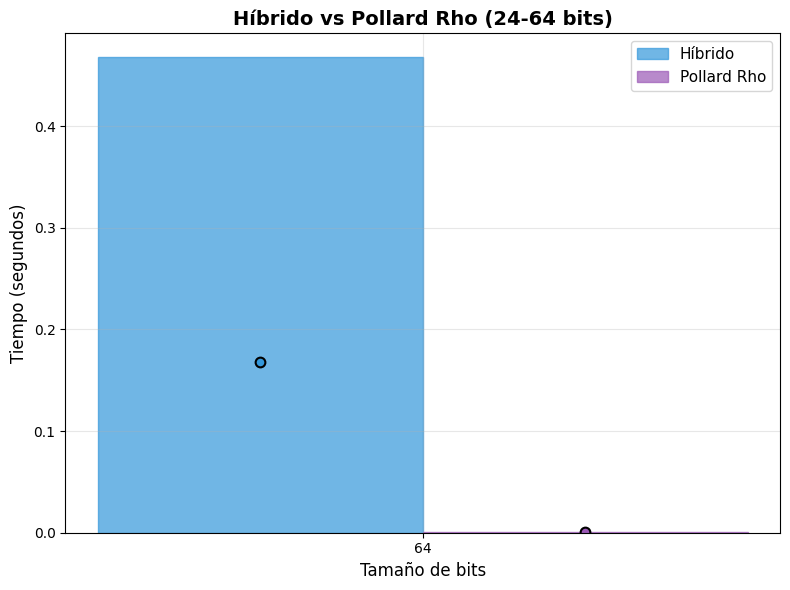

✅ Gráfico generado: Híbrido vs Pollard Rho (24-64 bits)
   Tamaños incluidos: [64]



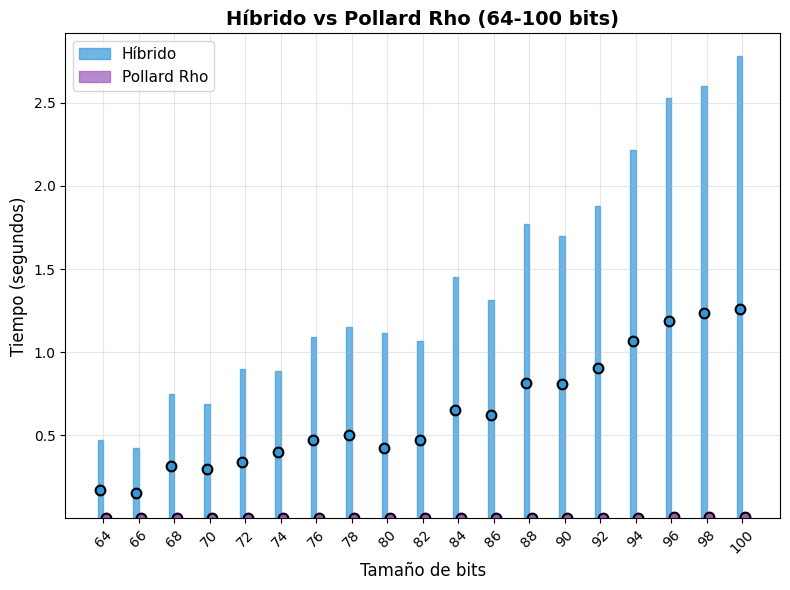

✅ Gráfico generado: Híbrido vs Pollard Rho (64-100 bits)
   Tamaños incluidos: [64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]



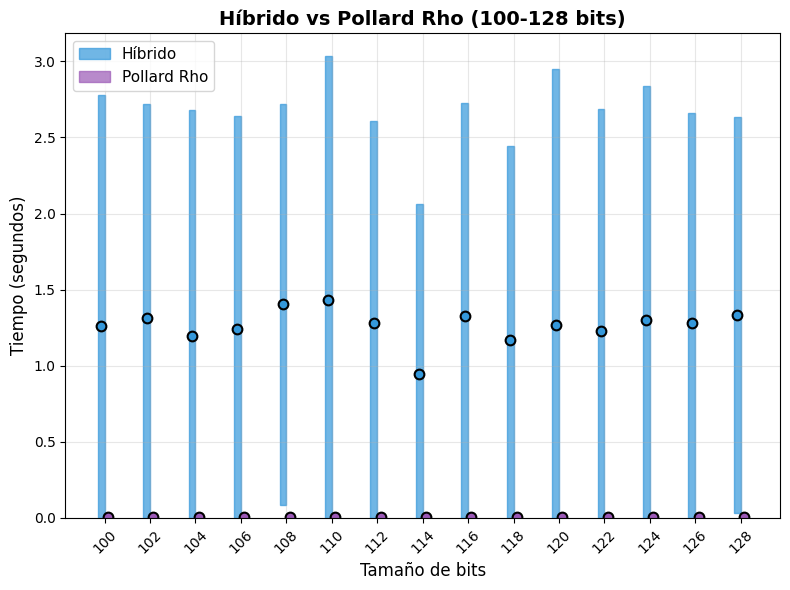

✅ Gráfico generado: Híbrido vs Pollard Rho (100-128 bits)
   Tamaños incluidos: [100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128]


ESTADÍSTICAS DE RENDIMIENTO POR MÉTODO Y TAMAÑO

Tamaño: 64 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
---------------------------------------------------------------------------
Híbrido              100   1.677e-01    3.000e-01    [0.000e+00, 4.678e-01]
Cc                   100   1.263e+00    2.613e-01    [1.002e+00, 1.525e+00]
Lenstra ECM          100   8.214e-04    6.444e-04    [1.769e-04, 1.466e-03]
Pollard Rho          100   2.788e-04    4.654e-04    [0.000e+00, 7.442e-04]

Tamaño: 66 bits
---------------------------------------------------------------------------
Método               N     Media (s)    Desv.Est     Rango [μ-σ, μ+σ]
---------------------------------------------------------------------------
Híbrido     

In [18]:
stats = analyze_factorization_performance(['resultados_debilesv2.txt'])

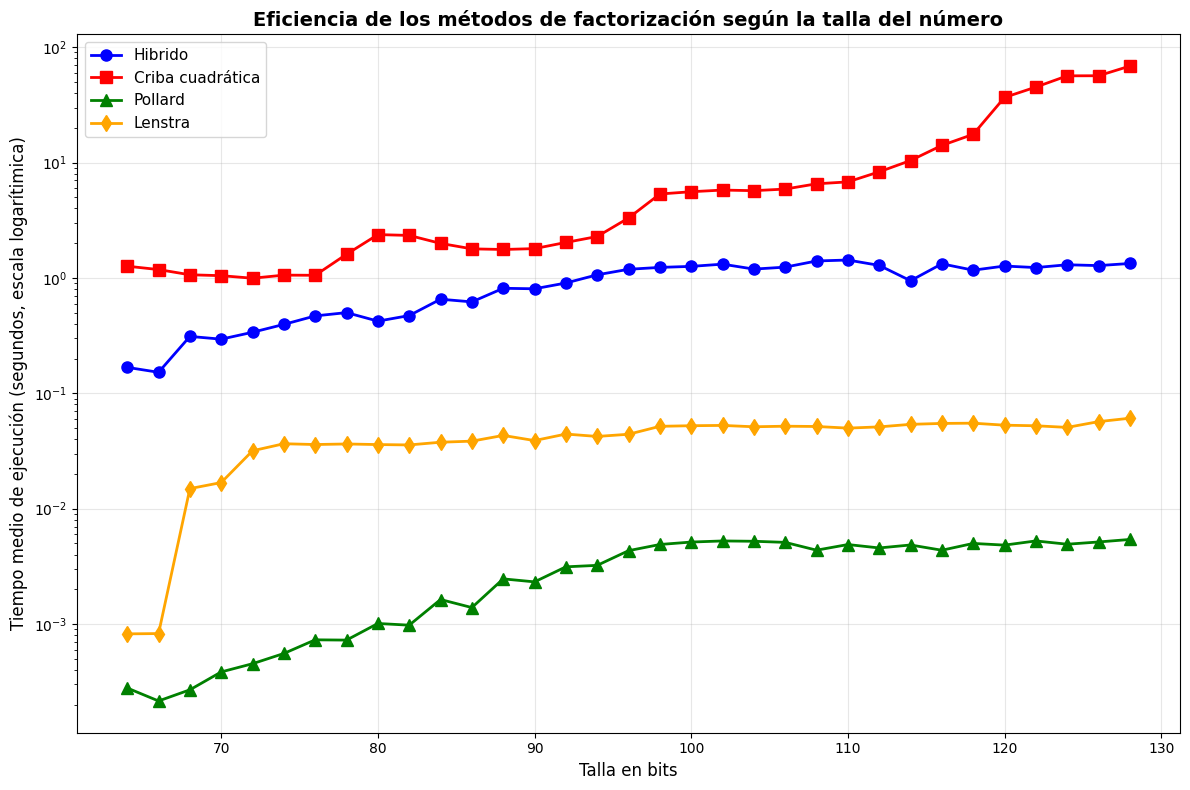

Analysis complete!
Error during analysis: name 'display_summary_statistics' is not defined


In [8]:
if __name__ == "__main__":
    files = ['resultados_debilesv2.txt']
    
    try:
        df, agg_df, fig = analyze_factorization_times(files, custom_labels={'cc_time': 'Criba cuadrática'})
        plt.show()
        print("Analysis complete!")
        display_summary_statistics(df, agg_df)
    except FileNotFoundError as e:
        print(f"Error: Could not find file. {e}")
    except Exception as e:
        print(f"Error during analysis: {e}")